# SIIM: Step-by-Step Image Detection for Beginners [In Progress..]

Thanks for nice reference : 

`handling dcm file`
- [SIIM-FISABIO-RSNA_COVID-19_Detection_Starter, DrCapa](https://www.kaggle.com/drcapa/siim-fisabio-rsna-covid-19-detection-starter)

`Image Visualization`
- [2. ONE STOP:Understanding+InDepth EDA+Model](https://www.kaggle.com/harshsharma511/one-stop-understanding-indepth-eda-model-progress)

`using gdcm without internet access`
- [pydicom_conda_helper](https://www.kaggle.com/awsaf49/pydicom-conda-helper)

```
Step 1. Import Libraries
Step 2. Load Data
Step 3. Read DCM File
     3-a. explore path with python code
     3-b. make image extractor(function)
Step 4. Show Sample Image
     4-a. explore image data with python code
     4-b. check position to draw box
Step 5. Show Multiple Images
Step 6. Feature Engineering I
     6-a. count opacity
     6-b. simplify 'id'
     6-c. rename colume 'id' to 'StudyInstanceUID for merge on 'StudyInstanceUID'
     6-d. check the relation between 'OpacityCount' and other columes in train_study
     6-e. visualize the relation between 'OpacityCount' and other columes in train_study
     6-f. check duplicate values(One row and Two Appearances)
Step 7. Feature Engineering II
     7-a. explore data analysis
     7-b. check duplicates in dataset
     7-c. modify some of the code in function that extract image(.dcm)
Step 8. Visualize X-ray with bbox
     8-a. negative for pneumonia
     8-b. typical appearance
     8-c. indeterminate appearance
     8-d. atypical Appearance
Step 9. Featrue Engineering III
     9-a. anomaly detection
     9-b. show outliers in `Typical Appearance`
     9-c. show outliers in `Intermiate Appearance`
     9-d. show outliers in `Atypical Appearance`
     ...ing
```  

## Step 1. Import Libraries

We need to load the gdcm package before import `pydicom`. because some of the dcm files are `jpeg lossless` type.

In [1]:
!wget 'https://anaconda.org/conda-forge/gdcm/2.8.9/download/linux-64/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -q
!conda install 'gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y


######################################################################## | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pydicom as dicom
import cv2
import ast
import warnings
warnings.filterwarnings('ignore')

## Step 2. Load Data

In [4]:
path = '/kaggle/input/siim-covid19-detection/'

In [5]:
os.listdir(path)

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

In [6]:
train_image = pd.read_csv(path+'train_image_level.csv')
train_study = pd.read_csv(path+'train_study_level.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

In [7]:
len(sample_submission)

2477

In [8]:
train_image

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                        none 1 0 0 1 1     ff0879eb20ed  
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e  
...                                                 ...              ...  
6329                                     none 1 0 0 1 1     7e6c68462e06  
6330                                     none 1 0 0 1 1     8332bdaddb6e  
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814  
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d  
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8  

[6334 rows x 4 columns]

In [9]:
train_study

id  Negative for Pneumonia  Typical Appearance  \
0     00086460a852_study                       0                   1   
1     000c9c05fd14_study                       0                   0   
2     00292f8c37bd_study                       1                   0   
3     005057b3f880_study                       1                   0   
4     0051d9b12e72_study                       0                   0   
...                  ...                     ...                 ...   
6049  ffcb4630f46f_study                       0                   1   
6050  ffe4d6e8fbb0_study                       0                   1   
6051  ffe94fcb14fa_study                       0                   1   
6052  ffebf1ef4a9c_study                       0                   1   
6053  fff649d65f62_study                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    1  
2                            0                    0  
3                            0                    0  
4                            0                    1  
...                        ...                  ...  
6049                         0                    0  
6050                         0                    0  
6051                         0                    0  
6052                         0                    0  
6053                         0                    0  

[6054 rows x 5 columns]

## Step 3. Read DCM File

### 3-a. explore path with python code

In [10]:
temp = train_image.loc[0, 'StudyInstanceUID']
temp

'5776db0cec75'

In [11]:
temp_depth2 = os.listdir(path+'train/'+temp)
temp_depth2[0]

'81456c9c5423'

In [12]:
temp_train_path = path+'train/'+temp+'/'+temp_depth2[0]
temp_train_path

'/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423'

In [13]:
os.listdir('/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423')  

['000a312787f2.dcm']

In [14]:
train_image.loc[0, 'id']

'000a312787f2_image'

### 3-b. make image extractor(function)

In [15]:
def extraction(i):
    path_train = path + 'train/' + train_image.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image.loc[i, 'id'].replace('_image','.dcm')
    print(img_id)
    data_file = dicom.dcmread(path_train+img_id)
    img = data_file.pixel_array
    return img

## Step 4. Show Sample Image

### 4-a. Explore Image Data with python code

In [16]:
sample_img = extraction(0)

000a312787f2.dcm


In [17]:
sample_img

array([[2809, 2799, 2836, ...,   63, 1791,    0],
       [2815, 2804, 2861, ...,   63, 2540,    0],
       [2867, 2872, 2918, ...,   63, 2545,    0],
       ...,
       [  55,   55,   55, ...,   43,   43,    0],
       [  53,   53,   54, ...,   45,   43,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [18]:
sample_img.shape

(3488, 4256)

### 4-b. check position to draw box

In [19]:
train_image.loc[0, 'boxes']

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [20]:
boxes = ast.literal_eval(train_image.loc[0, 'boxes'])
boxes

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

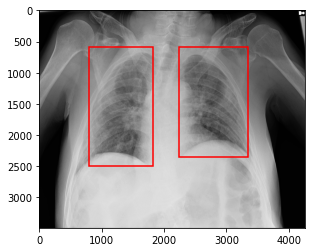

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(sample_img, cmap='gray')
plt.show()


## Step 5. Show Multiple Images

000a312787f2.dcm
000c3a3f293f.dcm
0012ff7358bc.dcm
001398f4ff4f.dcm
001bd15d1891.dcm
0022227f5adf.dcm
0023f02ae886.dcm
002e9b2128d0.dcm
00326161e51e.dcm


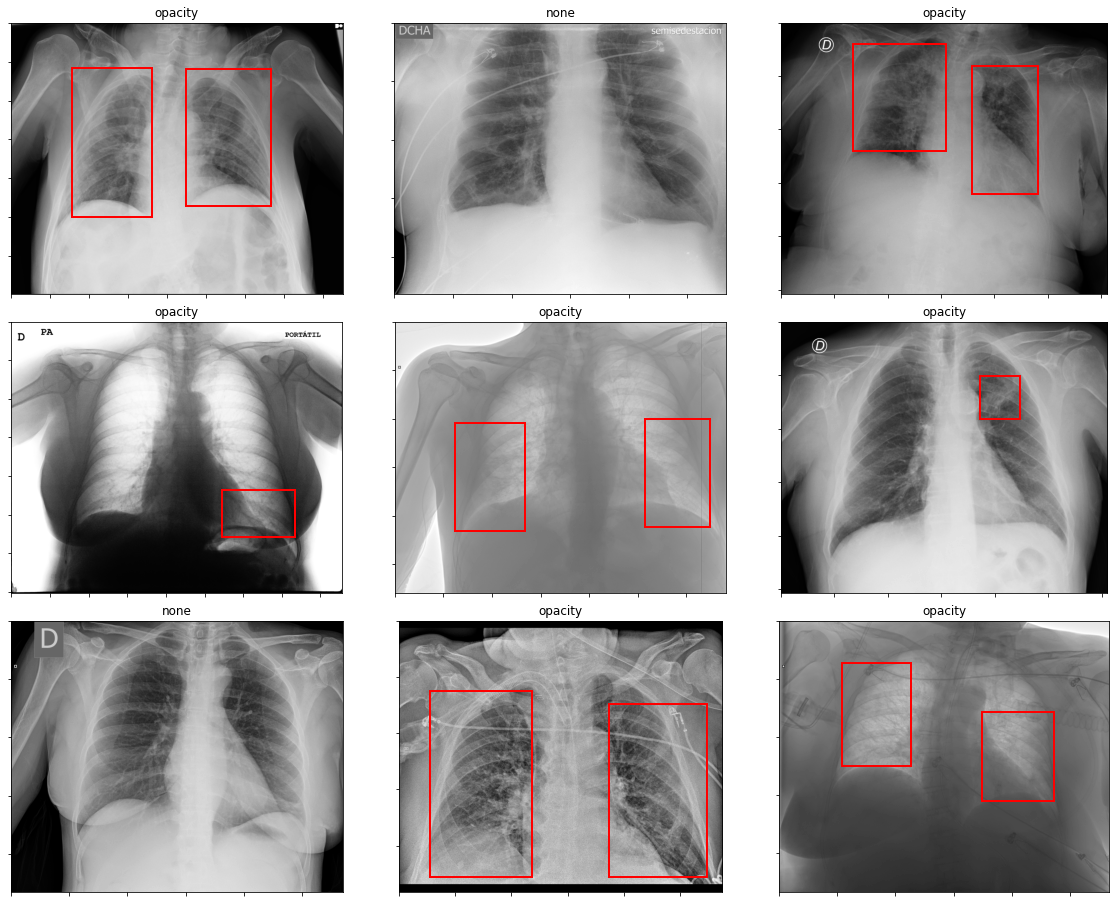

In [22]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

for row in range(9):
    img = extraction(row)
    # if (nan == nan)
    # False
    if (train_image.loc[row,'boxes'] == train_image.loc[row,'boxes']):
        boxes = ast.literal_eval(train_image.loc[row,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

## Step 6. Feature Engineering I

In [23]:
train_image

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                        none 1 0 0 1 1     ff0879eb20ed  
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e  
...                                                 ...              ...  
6329                                     none 1 0 0 1 1     7e6c68462e06  
6330                                     none 1 0 0 1 1     8332bdaddb6e  
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814  
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d  
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8  

[6334 rows x 4 columns]

### 6-a. Count Opacity in Image

In [24]:
OpacityCount = train_image['label'].str.count('opacity')
OpacityCount

0       2
1       0
2       2
3       1
4       2
       ..
6329    0
6330    0
6331    3
6332    2
6333    2
Name: label, Length: 6334, dtype: int64

In [25]:
train_image['OpacityCount'] = OpacityCount.values

In [26]:
train_image

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  
0                2  
1                0  
2                2  
3                1  
4                2  
...            ...  
6329             0  
6330             0  
6331             3  
6332             2  
6333             2  

[6334 rows x 5 columns]

In [27]:
train_image['id'].isnull().sum()

0

### 6-b. Simplify 'id' (study)

In [28]:
id_extract = lambda x : x[0]

In [29]:
train_study

id  Negative for Pneumonia  Typical Appearance  \
0     00086460a852_study                       0                   1   
1     000c9c05fd14_study                       0                   0   
2     00292f8c37bd_study                       1                   0   
3     005057b3f880_study                       1                   0   
4     0051d9b12e72_study                       0                   0   
...                  ...                     ...                 ...   
6049  ffcb4630f46f_study                       0                   1   
6050  ffe4d6e8fbb0_study                       0                   1   
6051  ffe94fcb14fa_study                       0                   1   
6052  ffebf1ef4a9c_study                       0                   1   
6053  fff649d65f62_study                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    1  
2                            0                    0  
3                            0                    0  
4                            0                    1  
...                        ...                  ...  
6049                         0                    0  
6050                         0                    0  
6051                         0                    0  
6052                         0                    0  
6053                         0                    0  

[6054 rows x 5 columns]

In [30]:
train_study['id'].isnull().sum()

0

In [31]:
train_study['id'].str.split('_')

0       [00086460a852, study]
1       [000c9c05fd14, study]
2       [00292f8c37bd, study]
3       [005057b3f880, study]
4       [0051d9b12e72, study]
                ...          
6049    [ffcb4630f46f, study]
6050    [ffe4d6e8fbb0, study]
6051    [ffe94fcb14fa, study]
6052    [ffebf1ef4a9c, study]
6053    [fff649d65f62, study]
Name: id, Length: 6054, dtype: object

In [32]:
train_study['id'].str.split('_').apply(id_extract)

0       00086460a852
1       000c9c05fd14
2       00292f8c37bd
3       005057b3f880
4       0051d9b12e72
            ...     
6049    ffcb4630f46f
6050    ffe4d6e8fbb0
6051    ffe94fcb14fa
6052    ffebf1ef4a9c
6053    fff649d65f62
Name: id, Length: 6054, dtype: object

In [33]:
train_study['id'] = train_study['id'].str.split('_').apply(id_extract)

In [34]:
sum(train_study['id'].str.contains(train_image['StudyInstanceUID'][0]))

1

### 6-c. rename colume 'id' to 'StudyInstanceUID for merge on 'StudyInstanceUID'

In [35]:
train_study = train_study.rename({'id':'StudyInstanceUID'}, axis=1)

In [36]:
train_study

StudyInstanceUID  Negative for Pneumonia  Typical Appearance  \
0        00086460a852                       0                   1   
1        000c9c05fd14                       0                   0   
2        00292f8c37bd                       1                   0   
3        005057b3f880                       1                   0   
4        0051d9b12e72                       0                   0   
...               ...                     ...                 ...   
6049     ffcb4630f46f                       0                   1   
6050     ffe4d6e8fbb0                       0                   1   
6051     ffe94fcb14fa                       0                   1   
6052     ffebf1ef4a9c                       0                   1   
6053     fff649d65f62                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    1  
2                            0                    0  
3                            0                    0  
4                            0                    1  
...                        ...                  ...  
6049                         0                    0  
6050                         0                    0  
6051                         0                    0  
6052                         0                    0  
6053                         0                    0  

[6054 rows x 5 columns]

In [37]:
train_df = pd.merge(train_image, train_study, on='StudyInstanceUID')
train_df

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
0                2                       0                   1   
1                0                       1                   0   
2                2                       0                   1   
3                1                       0                   0   
4                2                       0                   1   
...            ...                     ...                 ...   
6329             0                       1                   0   
6330             0                       1                   0   
6331             3                       0                   1   
6332             2                       0                   1   
6333             2                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    0  
2                            0                    0  
3                            0                    1  
4                            0                    0  
...                        ...                  ...  
6329                         0                    0  
6330                         0                    0  
6331                         0                    0  
6332                         0                    0  
6333                         0                    0  

[6334 rows x 9 columns]

### 6-d. Check the Relation between 'OpacityCount' and other Columes in train_study

In [38]:
train_df['OpacityCount'].value_counts()

2    3113
0    2040
1     973
3     183
4      23
8       1
5       1
Name: OpacityCount, dtype: int64

In [39]:
train_df.iloc[:,5:].columns

Index(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance'],
      dtype='object')

In [40]:
i = 5
for col in train_df.iloc[:,5:].columns:
    print('The Count of {} : '.format(col), sum(train_df.iloc[:,i]))
    i += 1

The Count of Negative for Pneumonia :  1736
The Count of Typical Appearance :  3007
The Count of Indeterminate Appearance :  1108
The Count of Atypical Appearance :  483


In [41]:
train_df[train_df['OpacityCount'] == 0]

id boxes           label StudyInstanceUID  OpacityCount  \
1     000c3a3f293f_image   NaN  none 1 0 0 1 1     ff0879eb20ed             0   
6     0023f02ae886_image   NaN  none 1 0 0 1 1     2fa400b873f5             0   
22    00c1515729a8_image   NaN  none 1 0 0 1 1     1a58b43cf286             0   
25    00e3a7e91a34_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
26    0d4d6acc9ed3_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
...                  ...   ...             ...              ...           ...   
6322  ff7659762b75_image   NaN  none 1 0 0 1 1     4aa11ef1fd38             0   
6324  ff9f10a24c27_image   NaN  none 1 0 0 1 1     a937614104e3             0   
6325  ffa9fef3c7bf_image   NaN  none 1 0 0 1 1     5133bbb7b75c             0   
6329  ffcc6edd9445_image   NaN  none 1 0 0 1 1     7e6c68462e06             0   
6330  ffd91a2c4ca0_image   NaN  none 1 0 0 1 1     8332bdaddb6e             0   

      Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
1                          1                   0                         0   
6                          1                   0                         0   
22                         0                   1                         0   
25                         1                   0                         0   
26                         1                   0                         0   
...                      ...                 ...                       ...   
6322                       1                   0                         0   
6324                       1                   0                         0   
6325                       1                   0                         0   
6329                       1                   0                         0   
6330                       1                   0                         0   

      Atypical Appearance  
1                       0  
6                       0  
22                      0  
25                      0  
26                      0  
...                   ...  
6322                    0  
6324                    0  
6325                    0  
6329                    0  
6330                    0  

[2040 rows x 9 columns]

In [42]:
OCount = sorted(list(train_df['OpacityCount'].value_counts().index))
print(OCount)

[0, 1, 2, 3, 4, 5, 8]


In [43]:
for count in OCount:
    print('Opacity Count = {}\n------------------------------'.format(count))
    print(train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum())
    print(' ')

Opacity Count = 0
------------------------------
Negative for Pneumonia      1736
Typical Appearance           153
Indeterminate Appearance      59
Atypical Appearance           92
dtype: int64
 
Opacity Count = 1
------------------------------
Negative for Pneumonia        0
Typical Appearance           27
Indeterminate Appearance    685
Atypical Appearance         261
dtype: int64
 
Opacity Count = 2
------------------------------
Negative for Pneumonia         0
Typical Appearance          2653
Indeterminate Appearance     345
Atypical Appearance          115
dtype: int64
 
Opacity Count = 3
------------------------------
Negative for Pneumonia        0
Typical Appearance          152
Indeterminate Appearance     17
Atypical Appearance          14
dtype: int64
 
Opacity Count = 4
------------------------------
Negative for Pneumonia       0
Typical Appearance          21
Indeterminate Appearance     1
Atypical Appearance          1
dtype: int64
 
Opacity Count = 5
------------------

### 6-e. Visualize the Relation between 'OpacityCount' and other Columes in train_study

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

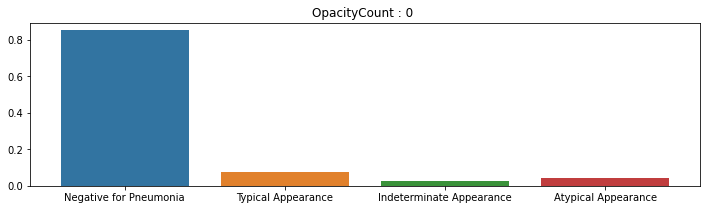

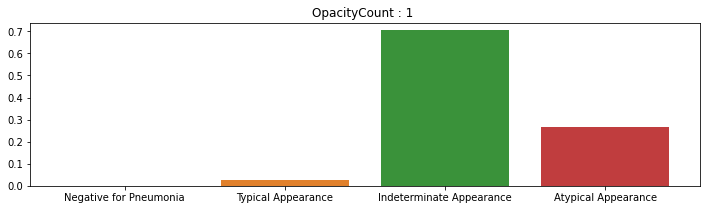

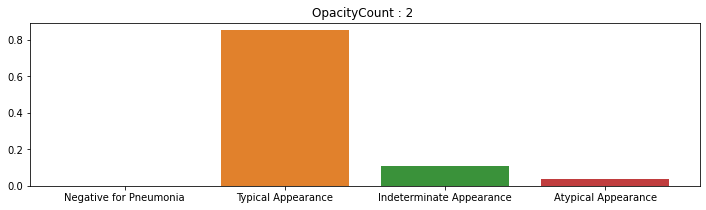

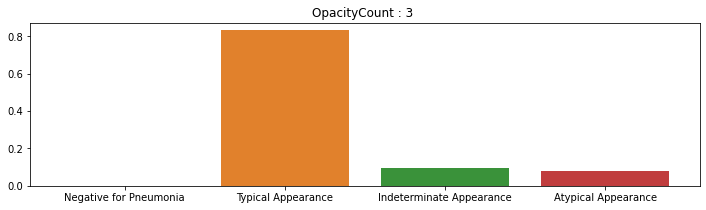

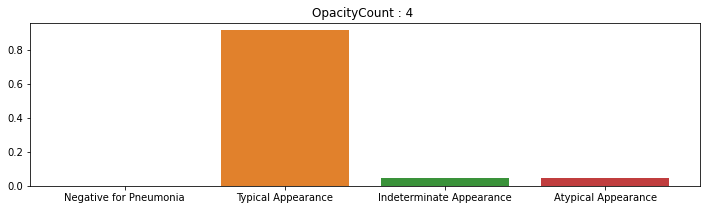

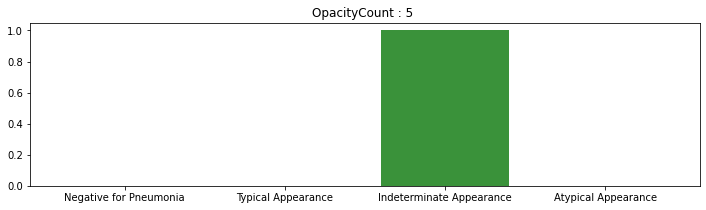

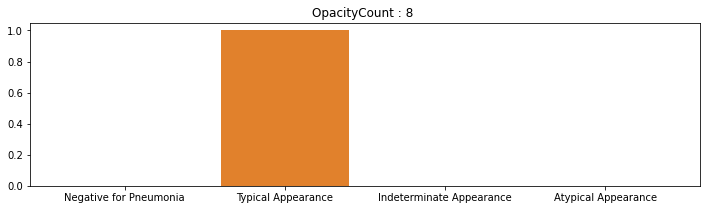

In [45]:
for count in OCount:
    Count_Series = train_df[train_df['OpacityCount'] == count].iloc[:,5:].sum()
    fig = plt.figure(figsize=(12,3))
    sns.barplot(x=Count_Series.index, y=Count_Series.values/sum(train_df['OpacityCount']==count))
    plt.title('OpacityCount : {} '.format(count))
    plt.plot();

### 6-f. Check Duplicate Values(One row and Two Appearances)

In [46]:
sum(train_df['OpacityCount']==1)

973

In [47]:
train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]

id                                              boxes  \
5     0022227f5adf_image  [{'x': 1857.2065, 'y': 508.30565, 'width': 376...   
18    00a129830f4e_image  [{'x': 496.23799, 'y': 1175.83357, 'width': 61...   
40    012f57190f1d_image  [{'x': 1440.88577, 'y': 1319.0304, 'width': 39...   
43    014a736182d3_image  [{'x': 1020.40636, 'y': 1463.8484, 'width': 10...   
45    015169fc4212_image  [{'x': 433.38881, 'y': 835.2, 'width': 641.866...   
...                  ...                                                ...   
6295  fe6a2dcda2da_image  [{'x': 2128.61914, 'y': 1797.93075, 'width': 5...   
6296  fe6cd1fbae72_image  [{'x': 1870.92927, 'y': 1410.89292, 'width': 4...   
6298  fe7fd0793fb3_image  [{'x': 723.8129, 'y': 918.02781, 'width': 481....   
6299  fe829429edc4_image  [{'x': 1968.89074, 'y': 1397.96122, 'width': 7...   
6309  fee6b3f57081_image  [{'x': 764.45953, 'y': 775.33251, 'width': 562...   

                                                  label StudyInstanceUID  \
5     opacity 1 1857.2065 508.30565 2233.23384 907.8...     84543edc24c2   
18    opacity 1 496.23799 1175.83357 1113.61823 1840...     3a3c198051f0   
40    opacity 1 1440.88577 1319.0304 1838.2981200000...     20eb74deaf29   
43    opacity 1 1020.40636 1463.8484 2091.12218 2373...     a33697e797cc   
45          opacity 1 433.38881 835.2 1075.25548 2238.8     528aca245f9a   
...                                                 ...              ...   
6295  opacity 1 2128.61914 1797.93075 2691.894039999...     7902e534869e   
6296  opacity 1 1870.92927 1410.89292 2311.73481 195...     bf21ae96901c   
6298  opacity 1 723.8129 918.02781 1204.824250000000...     07a2358b4e59   
6299  opacity 1 1968.89074 1397.96122 2762.55224 191...     aa4b16d18061   
6309  opacity 1 764.45953 775.33251 1326.49096 1642....     8dd03d75fbbc   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
5                1                       0                   0   
18               1                       0                   0   
40               1                       0                   0   
43               1                       0                   0   
45               1                       0                   0   
...            ...                     ...                 ...   
6295             1                       0                   0   
6296             1                       0                   0   
6298             1                       0                   0   
6299             1                       0                   0   
6309             1                       0                   0   

      Indeterminate Appearance  Atypical Appearance  
5                            1                    0  
18                           1                    0  
40                           1                    0  
43                           1                    0  
45                           1                    0  
...                        ...                  ...  
6295                         1                    0  
6296                         1                    0  
6298                         1                    0  
6299                         1                    0  
6309                         1                    0  

[685 rows x 9 columns]

In [48]:
train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]

id                                              boxes  \
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
16    008ca392cff3_image  [{'x': 2284.17508, 'y': 1342.64878, 'width': 1...   
124   0449b62bc0b6_image  [{'x': 1738.0842, 'y': 491.24506, 'width': 764...   
155   051c0c15073e_image  [{'x': 941.21661, 'y': 677.75974, 'width': 525...   
197   06f4f2f03a93_image  [{'x': 1862.59153, 'y': 1748.35, 'width': 593....   
...                  ...                                                ...   
6203  fa9ccef257cf_image  [{'x': 1976.45833, 'y': 1439.31252, 'width': 1...   
6219  fb832b7cf730_image  [{'x': 855.37671, 'y': 922.90918, 'width': 340...   
6220  fb8e258af5e3_image  [{'x': 597.48772, 'y': 1063.96189, 'width': 56...   
6300  fe94f73e3072_image  [{'x': 2887.40002, 'y': 1557.86664, 'width': 1...   
6318  ff339bf108b4_image  [{'x': 608.21586, 'y': 1747.03748, 'width': 75...   

                                                  label StudyInstanceUID  \
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
16    opacity 1 2284.17508 1342.64878 3307.2952 2708...     39a80a14bfda   
124   opacity 1 1738.0842 491.24506 2502.94284 1838....     b66a03d385b2   
155   opacity 1 941.21661 677.75974 1466.62181999999...     b65e52a96289   
197   opacity 1 1862.59153 1748.35 2456.551529999999...     1073d1b6ddcc   
...                                                 ...              ...   
6203  opacity 1 1976.45833 1439.31252 2148.70821 165...     f871e115903e   
6219  opacity 1 855.37671 922.90918 1195.37671 1690....     690a40dcd44c   
6220  opacity 1 597.48772 1063.96189 1167.4674 1844....     a27ab5ca843e   
6300  opacity 1 2887.40002 1557.86664 3987.40002 231...     9945a45c802e   
6318  opacity 1 608.21586 1747.03748 1366.61979 2302...     f4f46fb7a346   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
3                1                       0                   0   
16               1                       0                   0   
124              1                       0                   0   
155              1                       0                   0   
197              1                       0                   0   
...            ...                     ...                 ...   
6203             1                       0                   0   
6219             1                       0                   0   
6220             1                       0                   0   
6300             1                       0                   0   
6318             1                       0                   0   

      Indeterminate Appearance  Atypical Appearance  
3                            0                    1  
16                           0                    1  
124                          0                    1  
155                          0                    1  
197                          0                    1  
...                        ...                  ...  
6203                         0                    1  
6219                         0                    1  
6220                         0                    1  
6300                         0                    1  
6318                         0                    1  

[261 rows x 9 columns]

In [49]:
train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)]

id                                              boxes  \
369   0c65c1436864_image  [{'x': 1915.58278, 'y': 633.59996, 'width': 65...   
478   10b1352bfe36_image  [{'x': 779.02392, 'y': 1484.38274, 'width': 79...   
566   13b742f56244_image  [{'x': 1594.34016, 'y': 422.96599, 'width': 58...   
603   14fe3a3839c0_image  [{'x': 521.29667, 'y': 1306.27967, 'width': 51...   
711   1a0a148c030f_image  [{'x': 900.71579, 'y': 1330.48801, 'width': 61...   
830   1e9fe71f89bf_image  [{'x': 589.73334, 'y': 1758.20001, 'width': 10...   
891   20cde26bb6ff_image  [{'x': 625.48512, 'y': 735.50068, 'width': 289...   
1069  27bd4ea4ed28_image  [{'x': 236.25646, 'y': 1720.09565, 'width': 81...   
1319  31b0dc31da93_image  [{'x': 1763.60719, 'y': 886.20993, 'width': 80...   
1387  33cc8e10ccb0_image  [{'x': 829.37512, 'y': 1011.77033, 'width': 37...   
1555  3a750a490193_image  [{'x': 2005.97567, 'y': 782.27577, 'width': 33...   
2288  5709155133b4_image  [{'x': 2059.49333, 'y': 920.78668, 'width': 42...   
2389  5b322d104117_image  [{'x': 663.21977, 'y': 833.71093, 'width': 598...   
3197  7b121eb03179_image  [{'x': 541.63062, 'y': 580.01008, 'width': 455...   
3806  940996303881_image  [{'x': 790.2993, 'y': 1261.75782, 'width': 530...   
3883  9764ac3311c6_image  [{'x': 2533.23636, 'y': 676.94549, 'width': 77...   
3893  97f431ee7684_image  [{'x': 1795.98852, 'y': 1120.73114, 'width': 7...   
3971  9b4fdd3a6c98_image  [{'x': 1681.59998, 'y': 1474.09524, 'width': 2...   
4410  ae8fecc25309_image  [{'x': 64.66675, 'y': 1201.33341, 'width': 690...   
4439  afe51a83f018_image  [{'x': 2642.97635, 'y': 732.35095, 'width': 16...   
4597  b700a42eba4e_image  [{'x': 2038.12057, 'y': 573.66127, 'width': 56...   
4609  b77d1450dcb2_image  [{'x': 3258.78258, 'y': 1607.09753, 'width': 4...   
4696  ba77c4831e02_image  [{'x': 1949.02971, 'y': 1211.85289, 'width': 7...   
5155  cceb217b80ac_image  [{'x': 2269.40537, 'y': 508.80338, 'width': 59...   
5870  eb3be46c1a3b_image  [{'x': 3207.16904, 'y': 1379.94298, 'width': 1...   
5943  eef9600e5493_image  [{'x': 510.76848, 'y': 1349.47121, 'width': 93...   
6036  f37d85d13cdd_image  [{'x': 1862.83636, 'y': 1039.7215, 'width': 49...   

                                                  label StudyInstanceUID  \
369   opacity 1 1915.58278 633.59996 2572.43263 1730...     c6e1b0f07d2b   
478   opacity 1 779.02392 1484.38274 1578.3349600000...     7adea6f20461   
566   opacity 1 1594.34016 422.96599 2178.28572 1341...     ce61060be9c9   
603   opacity 1 521.29667 1306.27967 1040.22971 2028...     b2b9fffd2865   
711   opacity 1 900.71579 1330.48801 1517.76468 1982...     49374ea79cdd   
830   opacity 1 589.73334 1758.20001 1597.73334 2914...     48115244cd07   
891   opacity 1 625.48512 735.50068 915.112320000000...     a567703dcd4c   
1069  opacity 1 236.25646 1720.09565 1052.94544 2099...     a5303f2a4c73   
1319  opacity 1 1763.60719 886.20993 2572.09534 1810...     29cd2e8cd19c   
1387  opacity 1 829.37512 1011.77033 1205.64111 1645...     9fa2ca50548e   
1555  opacity 1 2005.97567 782.27577 2336.20968 1115...     8d4af13cfe6e   
2288  opacity 1 2059.49333 920.78668 2480.86662 1389...     98d13a3c4060   
2389  opacity 1 663.21977 833.71093 1261.78154 1435....     4b0df75f21f5   
3197  opacity 1 541.63062 580.01008 997.45838 1159.1...     3ff7ee335606   
3806  opacity 1 790.2993 1261.75782 1321.06395 1601....     d74b6ea0d497   
3883  opacity 1 2533.23636 676.94549 3311.12723 1678...     3ab0b0a2f8ac   
3893  opacity 1 1795.98852 1120.73114 2559.065910000...     a34c88047a71   
3971  opacity 1 1681.59998 1474.09524 1939.04761 169...     4f0201c0929f   
4410  opacity 1 64.66675 1201.33341 755.33325 1790.6...     a072ab44ba69   
4439  opacity 1 2642.97635 732.35095 2804.28714 1251...     481267fb221a   
4597  opacity 1 2038.12057 573.66127 2605.32052 1545...     160c3b649efd   
4609  opacity 1 3258.78258 1607.09753 3741.32067 218...     42ad2e4feb4f   
4696  opacity 1 1949.02971 1211.85289 2652.97356 217...     d

In [50]:
len(train_df[(train_df['OpacityCount']==1)&(train_df['Indeterminate Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Atypical Appearance'] == 1)]) + len(train_df[(train_df['OpacityCount']==1)&(train_df['Typical Appearance'] == 1)])

973

In [51]:
sum(train_df['OpacityCount']==1)

973

In [52]:
sample_submission

id    PredictionString
0     00188a671292_study  negative 1 0 0 1 1
1     004bd59708be_study  negative 1 0 0 1 1
2     00508faccd39_study  negative 1 0 0 1 1
3     006486aa80b2_study  negative 1 0 0 1 1
4     00655178fdfc_study  negative 1 0 0 1 1
...                  ...                 ...
2472  46719b856de1_image      none 1 0 0 1 1
2473  31c07523a69a_image      none 1 0 0 1 1
2474  f77d7d1aebab_image      none 1 0 0 1 1
2475  ccc5b63ca96d_image      none 1 0 0 1 1
2476  5e8ac1fe2b82_image      none 1 0 0 1 1

[2477 rows x 2 columns]

## Step 7. Feature Engineering II

### 7-a. explore data analysis

The number of `StudyInstanceUID` in train_study(original id) is different from the number of `StudyInstanceUID` in train_df(==train_image)

Let's check them

In [53]:
train_study

StudyInstanceUID  Negative for Pneumonia  Typical Appearance  \
0        00086460a852                       0                   1   
1        000c9c05fd14                       0                   0   
2        00292f8c37bd                       1                   0   
3        005057b3f880                       1                   0   
4        0051d9b12e72                       0                   0   
...               ...                     ...                 ...   
6049     ffcb4630f46f                       0                   1   
6050     ffe4d6e8fbb0                       0                   1   
6051     ffe94fcb14fa                       0                   1   
6052     ffebf1ef4a9c                       0                   1   
6053     fff649d65f62                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    1  
2                            0                    0  
3                            0                    0  
4                            0                    1  
...                        ...                  ...  
6049                         0                    0  
6050                         0                    0  
6051                         0                    0  
6052                         0                    0  
6053                         0                    0  

[6054 rows x 5 columns]

In [54]:
train_image

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  
0                2  
1                0  
2                2  
3                1  
4                2  
...            ...  
6329             0  
6330             0  
6331             3  
6332             2  
6333             2  

[6334 rows x 5 columns]

In [55]:
train_df

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
0                2                       0                   1   
1                0                       1                   0   
2                2                       0                   1   
3                1                       0                   0   
4                2                       0                   1   
...            ...                     ...                 ...   
6329             0                       1                   0   
6330             0                       1                   0   
6331             3                       0                   1   
6332             2                       0                   1   
6333             2                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    0  
2                            0                    0  
3                            0                    1  
4                            0                    0  
...                        ...                  ...  
6329                         0                    0  
6330                         0                    0  
6331                         0                    0  
6332                         0                    0  
6333                         0                    0  

[6334 rows x 9 columns]

In [56]:
len(train_df['StudyInstanceUID'])

6334

In [57]:
len(train_df['StudyInstanceUID'].unique())

6054

### 7-b. Check duplicates in dataset

We can find that No duplicates in train_study(original ID) because the length of unique `StudyInstanceUID` in train_df and the length of train_study's rows are the same

In [58]:
train_image['StudyInstanceUID'].unique().sort() == train_study['StudyInstanceUID'].unique().sort()

True

In [59]:
len(train_image['StudyInstanceUID'].unique())

6054

Naturally, because `train_df` is a merged data frame based on `train_image`, `train_image` has also the same result.

Now, Let's check duplicated images(id)

In [60]:
train_image[train_image.duplicated(['StudyInstanceUID'])==True]['StudyInstanceUID']

156     0fd2db233deb
289     a0254bf8a96e
346     74ba8f2badcb
459     bc3e2b05a7f1
551     0fd2db233deb
            ...     
6191    76b5e2db22ba
6194    abd0c3d9c5f6
6210    2edd69dd0934
6217    350cd603e64d
6239    77539184cdaf
Name: StudyInstanceUID, Length: 280, dtype: object

In [61]:
du_StudyId = train_image[train_image.duplicated(['StudyInstanceUID'])==True]['StudyInstanceUID'].values

In [62]:
du_images = train_image[train_image['StudyInstanceUID'].isin(du_StudyId)].sort_values(by=['StudyInstanceUID'])
du_images

id                                              boxes  \
2862  74077a8e3b7c_image  [{'x': 2175.24285, 'y': 1123.72368, 'width': 4...   
2490  6534a837497d_image                                                NaN   
2119  55e22c0c5de0_image  [{'x': 455.99999, 'y': 1480.00008, 'width': 26...   
6061  f5451a98d684_image                                                NaN   
3880  9e4824fcee2e_image  [{'x': 817.77961, 'y': 1075.34501, 'width': 64...   
...                  ...                                                ...   
1600  4123a71d9796_image  [{'x': 889.45144, 'y': 282.39441, 'width': 825...   
827   218bcf950372_image                                                NaN   
5735  e6cc65d9de1d_image                                                NaN   
3277  84ed5f7f71bf_image  [{'x': 1721.27651, 'y': 974.09667, 'width': 12...   
710   1c96d9b08487_image                                                NaN   

                                                  label StudyInstanceUID  \
2862  opacity 1 2175.24285 1123.72368 2607.50603 162...     00f9e183938e   
2490                                     none 1 0 0 1 1     00f9e183938e   
2119  opacity 1 455.99999 1480.00008 722.39998 2437....     0142feaef82f   
6061                                     none 1 0 0 1 1     0142feaef82f   
3880  opacity 1 817.77961 1075.34501 1467.08961 2075...     0369e0385796   
...                                                 ...              ...   
1600  opacity 1 889.45144 282.39441 1714.51125 1585....     fc45007f145a   
827                                      none 1 0 0 1 1     fd92c6f2b2e6   
5735                                     none 1 0 0 1 1     fd92c6f2b2e6   
3277  opacity 1 1721.27651 974.09667 2999.21998 2681...     ffcb4630f46f   
710                                      none 1 0 0 1 1     ffcb4630f46f   

      OpacityCount  
2862             3  
2490             0  
2119             1  
6061             0  
3880             2  
...            ...  
1600             2  
827              0  
5735             0  
3277             2  
710              0  

[512 rows x 5 columns]

```
232 original ID
280 duplicate ID
```

- one or more duplicate Image at the same ID

### 7-c. modify some of the code in function that extract image(.dcm)

So, Some of the code(function extraction) needs to be modified to accurately target the image to be extracted.

Duplicate ID - ex. 1 ID(74ba8f2badcb) - 4 Path(in each path, All 4 Images are the same)

In [63]:
train_df[train_df['StudyInstanceUID'].str.contains('74ba8f2')]

id boxes           label StudyInstanceUID  OpacityCount  \
25  00e3a7e91a34_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
26  0d4d6acc9ed3_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
27  93a881fb3292_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
28  cdd9e3aaf45a_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   

    Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
25                       1                   0                         0   
26                       1                   0                         0   
27                       1                   0                         0   
28                       1                   0                         0   

    Atypical Appearance  
25                    0  
26                    0  
27                    0  
28                    0

In [64]:
os.listdir(path + 'train/' + '74ba8f2badcb')

['51da3f27b9a8', 'b9e7a4279b83', 'c8755f476425', '6452802696f6']

In [65]:
long_path = path + 'train/' + '74ba8f2badcb/'
for i in os.listdir(long_path):
    print(os.listdir(long_path+i))

['cdd9e3aaf45a.dcm']
['0d4d6acc9ed3.dcm']
['00e3a7e91a34.dcm']
['93a881fb3292.dcm']


In [66]:
os.listdir('/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93')

['000c3a3f293f.dcm']


Search all paths through a loop and check whether it matches the id value.

In [67]:
def error_processed_extraction(i):
    long_path = path + 'train/' + train_df.loc[i, 'StudyInstanceUID'] + '/'
    img_id = train_df.loc[i, 'id'].replace('_image','.dcm')
    for dcm in os.listdir(long_path):
        dcm_path = long_path+dcm+'/'
        if img_id == os.listdir(dcm_path)[0]:
            data_file = dicom.dcmread(dcm_path+img_id)
            print('index : {} - DCM File Path :{}'.format(i, dcm_path+img_id))
        else:
            continue
            
    img = data_file.pixel_array
    return img

## 8. Visualize X-ray with bbox

In [68]:
OpacityType = list(train_df.iloc[:,5:].columns)
OpacityType

['Negative for Pneumonia',
 'Typical Appearance',
 'Indeterminate Appearance',
 'Atypical Appearance']

In [69]:
train_df[train_df[OpacityType[0]]==1]

id boxes           label StudyInstanceUID  OpacityCount  \
1     000c3a3f293f_image   NaN  none 1 0 0 1 1     ff0879eb20ed             0   
6     0023f02ae886_image   NaN  none 1 0 0 1 1     2fa400b873f5             0   
25    00e3a7e91a34_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
26    0d4d6acc9ed3_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
27    93a881fb3292_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
...                  ...   ...             ...              ...           ...   
6322  ff7659762b75_image   NaN  none 1 0 0 1 1     4aa11ef1fd38             0   
6324  ff9f10a24c27_image   NaN  none 1 0 0 1 1     a937614104e3             0   
6325  ffa9fef3c7bf_image   NaN  none 1 0 0 1 1     5133bbb7b75c             0   
6329  ffcc6edd9445_image   NaN  none 1 0 0 1 1     7e6c68462e06             0   
6330  ffd91a2c4ca0_image   NaN  none 1 0 0 1 1     8332bdaddb6e             0   

      Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
1                          1                   0                         0   
6                          1                   0                         0   
25                         1                   0                         0   
26                         1                   0                         0   
27                         1                   0                         0   
...                      ...                 ...                       ...   
6322                       1                   0                         0   
6324                       1                   0                         0   
6325                       1                   0                         0   
6329                       1                   0                         0   
6330                       1                   0                         0   

      Atypical Appearance  
1                       0  
6                       0  
25                      0  
26                      0  
27                      0  
...                   ...  
6322                    0  
6324                    0  
6325                    0  
6329                    0  
6330                    0  

[1736 rows x 9 columns]

### 8-a. Negative for Pneumonia

In [70]:
Negative_Idx = list(train_df[train_df[OpacityType[0]]==1].index)
Negative_Idx[:9]

[1, 6, 25, 26, 27, 28, 30, 34, 35]

In [71]:
train_df.iloc[Negative_Idx, :]

id boxes           label StudyInstanceUID  OpacityCount  \
1     000c3a3f293f_image   NaN  none 1 0 0 1 1     ff0879eb20ed             0   
6     0023f02ae886_image   NaN  none 1 0 0 1 1     2fa400b873f5             0   
25    00e3a7e91a34_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
26    0d4d6acc9ed3_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
27    93a881fb3292_image   NaN  none 1 0 0 1 1     74ba8f2badcb             0   
...                  ...   ...             ...              ...           ...   
6322  ff7659762b75_image   NaN  none 1 0 0 1 1     4aa11ef1fd38             0   
6324  ff9f10a24c27_image   NaN  none 1 0 0 1 1     a937614104e3             0   
6325  ffa9fef3c7bf_image   NaN  none 1 0 0 1 1     5133bbb7b75c             0   
6329  ffcc6edd9445_image   NaN  none 1 0 0 1 1     7e6c68462e06             0   
6330  ffd91a2c4ca0_image   NaN  none 1 0 0 1 1     8332bdaddb6e             0   

      Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
1                          1                   0                         0   
6                          1                   0                         0   
25                         1                   0                         0   
26                         1                   0                         0   
27                         1                   0                         0   
...                      ...                 ...                       ...   
6322                       1                   0                         0   
6324                       1                   0                         0   
6325                       1                   0                         0   
6329                       1                   0                         0   
6330                       1                   0                         0   

      Atypical Appearance  
1                       0  
6                       0  
25                      0  
26                      0  
27                      0  
...                   ...  
6322                    0  
6324                    0  
6325                    0  
6329                    0  
6330                    0  

[1736 rows x 9 columns]

index : 1 - DCM File Path :/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
index : 6 - DCM File Path :/kaggle/input/siim-covid19-detection/train/2fa400b873f5/0d5c637b277d/0023f02ae886.dcm
index : 25 - DCM File Path :/kaggle/input/siim-covid19-detection/train/74ba8f2badcb/c8755f476425/00e3a7e91a34.dcm
index : 26 - DCM File Path :/kaggle/input/siim-covid19-detection/train/74ba8f2badcb/b9e7a4279b83/0d4d6acc9ed3.dcm
index : 27 - DCM File Path :/kaggle/input/siim-covid19-detection/train/74ba8f2badcb/6452802696f6/93a881fb3292.dcm
index : 28 - DCM File Path :/kaggle/input/siim-covid19-detection/train/74ba8f2badcb/51da3f27b9a8/cdd9e3aaf45a.dcm
index : 30 - DCM File Path :/kaggle/input/siim-covid19-detection/train/2a7b4e669dda/56124a55d874/010214f9b600.dcm
index : 34 - DCM File Path :/kaggle/input/siim-covid19-detection/train/e15b98946bf7/baba723e4a01/010433f32857.dcm
index : 35 - DCM File Path :/kaggle/input/siim-covid19-detection/train/7ecdff541fd7/06d889

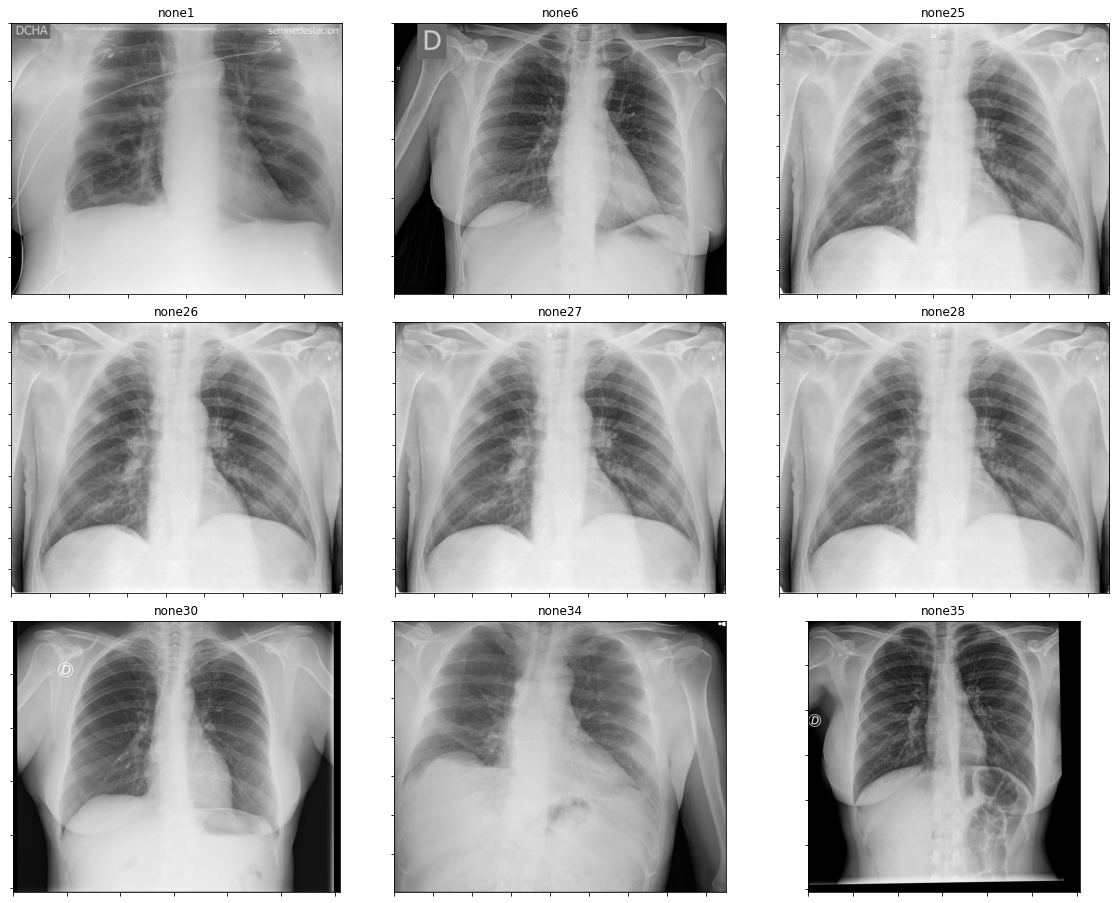

In [72]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Negative_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(str(train_df.loc[idx, 'label'].split(' ')[0])+ str(idx))
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 8-b. Typical Appearance

In [73]:
Typical_Idx = list(train_df[train_df[OpacityType[1]]==1].index)
Typical_Idx[:9]

[0, 2, 4, 7, 8, 9, 10, 11, 12]

In [74]:
train_df.iloc[Typical_Idx, :]

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
7     002e9b2128d0_image  [{'x': 276.72917, 'y': 627.42968, 'width': 910...   
8     00326161e51e_image  [{'x': 542.96057, 'y': 364.37257, 'width': 590...   
...                  ...                                                ...   
6327  ffbeafe30b77_image  [{'x': 1472.09879, 'y': 1182.64415, 'width': 3...   
6328  ffcc16bbf428_image  [{'x': 2529.03977, 'y': 347.67053, 'width': 58...   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
7     opacity 1 276.72917 627.42968 1187.31776 2283....     0717c8ac304f   
8     opacity 1 542.96057 364.37257 1133.32317999999...     a81050391441   
...                                                 ...              ...   
6327  opacity 1 1472.09879 1182.64415 1773.17398 146...     f75774536369   
6328  opacity 1 2529.03977 347.67053 3113.65526 1484...     5d786634f354   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
0                2                       0                   1   
2                2                       0                   1   
4                2                       0                   1   
7                2                       0                   1   
8                2                       0                   1   
...            ...                     ...                 ...   
6327             2                       0                   1   
6328             2                       0                   1   
6331             3                       0                   1   
6332             2                       0                   1   
6333             2                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
2                            0                    0  
4                            0                    0  
7                            0                    0  
8                            0                    0  
...                        ...                  ...  
6327                         0                    0  
6328                         0                    0  
6331                         0                    0  
6332                         0                    0  
6333                         0                    0  

[3007 rows x 9 columns]

index : 0 - DCM File Path :/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
index : 2 - DCM File Path :/kaggle/input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
index : 4 - DCM File Path :/kaggle/input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm
index : 7 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0717c8ac304f/849b8c217a5e/002e9b2128d0.dcm
index : 8 - DCM File Path :/kaggle/input/siim-covid19-detection/train/a81050391441/85b77baa8ffe/00326161e51e.dcm
index : 9 - DCM File Path :/kaggle/input/siim-covid19-detection/train/b60f2d2cc642/72527a76d460/0044e449aae1.dcm
index : 10 - DCM File Path :/kaggle/input/siim-covid19-detection/train/4d7a2748dfb1/49f74cf4cbad/0049814626c8.dcm
index : 11 - DCM File Path :/kaggle/input/siim-covid19-detection/train/30e45593ba08/c5c0a57e6e4c/004cbd797cd1.dcm
index : 12 - DCM File Path :/kaggle/input/siim-covid19-detection/train/02e31620e4e7/fb593f9b0d

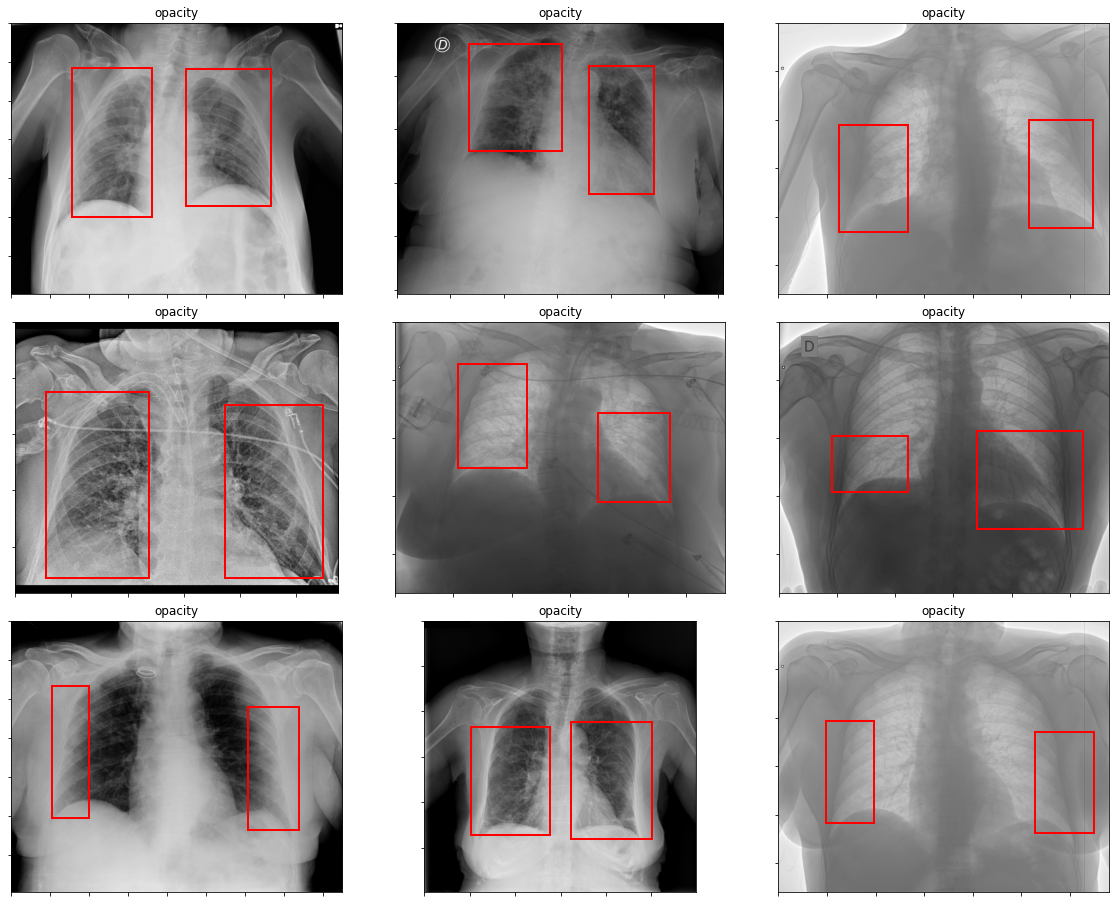

In [75]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Typical_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 8-c. Indeterminate Appearance

In [76]:
Indeterminate_Idx = list(train_df[train_df[OpacityType[2]]==1].index)
Indeterminate_Idx[:9]

[5, 18, 40, 42, 43, 45, 48, 51, 61]

In [77]:
train_df.iloc[Indeterminate_Idx, :]

id                                              boxes  \
5     0022227f5adf_image  [{'x': 1857.2065, 'y': 508.30565, 'width': 376...   
18    00a129830f4e_image  [{'x': 496.23799, 'y': 1175.83357, 'width': 61...   
40    012f57190f1d_image  [{'x': 1440.88577, 'y': 1319.0304, 'width': 39...   
42    01376c1ba556_image  [{'x': 696.48983, 'y': 1070.04082, 'width': 10...   
43    014a736182d3_image  [{'x': 1020.40636, 'y': 1463.8484, 'width': 10...   
...                  ...                                                ...   
6296  fe6cd1fbae72_image  [{'x': 1870.92927, 'y': 1410.89292, 'width': 4...   
6298  fe7fd0793fb3_image  [{'x': 723.8129, 'y': 918.02781, 'width': 481....   
6299  fe829429edc4_image  [{'x': 1968.89074, 'y': 1397.96122, 'width': 7...   
6309  fee6b3f57081_image  [{'x': 764.45953, 'y': 775.33251, 'width': 562...   
6319  ff46eefd123c_image  [{'x': 1008.12981, 'y': 528.61356, 'width': 15...   

                                                  label StudyInstanceUID  \
5     opacity 1 1857.2065 508.30565 2233.23384 907.8...     84543edc24c2   
18    opacity 1 496.23799 1175.83357 1113.61823 1840...     3a3c198051f0   
40    opacity 1 1440.88577 1319.0304 1838.2981200000...     20eb74deaf29   
42    opacity 1 696.48983 1070.04082 1757.0613 2367....     3c88bd82fb37   
43    opacity 1 1020.40636 1463.8484 2091.12218 2373...     a33697e797cc   
...                                                 ...              ...   
6296  opacity 1 1870.92927 1410.89292 2311.73481 195...     bf21ae96901c   
6298  opacity 1 723.8129 918.02781 1204.824250000000...     07a2358b4e59   
6299  opacity 1 1968.89074 1397.96122 2762.55224 191...     aa4b16d18061   
6309  opacity 1 764.45953 775.33251 1326.49096 1642....     8dd03d75fbbc   
6319  opacity 1 1008.12981 528.61356 1160.93212 669....     5a0e35234db3   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
5                1                       0                   0   
18               1                       0                   0   
40               1                       0                   0   
42               2                       0                   0   
43               1                       0                   0   
...            ...                     ...                 ...   
6296             1                       0                   0   
6298             1                       0                   0   
6299             1                       0                   0   
6309             1                       0                   0   
6319             2                       0                   0   

      Indeterminate Appearance  Atypical Appearance  
5                            1                    0  
18                           1                    0  
40                           1                    0  
42                           1                    0  
43                           1                    0  
...                        ...                  ...  
6296                         1                    0  
6298                         1                    0  
6299                         1                    0  
6309                         1                    0  
6319                         1                    0  

[1108 rows x 9 columns]

index : 5 - DCM File Path :/kaggle/input/siim-covid19-detection/train/84543edc24c2/82f65ab98ee0/0022227f5adf.dcm
index : 18 - DCM File Path :/kaggle/input/siim-covid19-detection/train/3a3c198051f0/e38a48e1f5ab/00a129830f4e.dcm
index : 40 - DCM File Path :/kaggle/input/siim-covid19-detection/train/20eb74deaf29/4134e2ae012e/012f57190f1d.dcm
index : 42 - DCM File Path :/kaggle/input/siim-covid19-detection/train/3c88bd82fb37/c3b35d1172dc/01376c1ba556.dcm
index : 43 - DCM File Path :/kaggle/input/siim-covid19-detection/train/a33697e797cc/69ccac342782/014a736182d3.dcm
index : 45 - DCM File Path :/kaggle/input/siim-covid19-detection/train/528aca245f9a/525fbdb19672/015169fc4212.dcm
index : 48 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0e9bece7e297/020a242ad6ab/01685340af75.dcm
index : 51 - DCM File Path :/kaggle/input/siim-covid19-detection/train/6de130752a73/055f52a8d21a/018343ac5c25.dcm
index : 61 - DCM File Path :/kaggle/input/siim-covid19-detection/train/afdda33a1265/da694

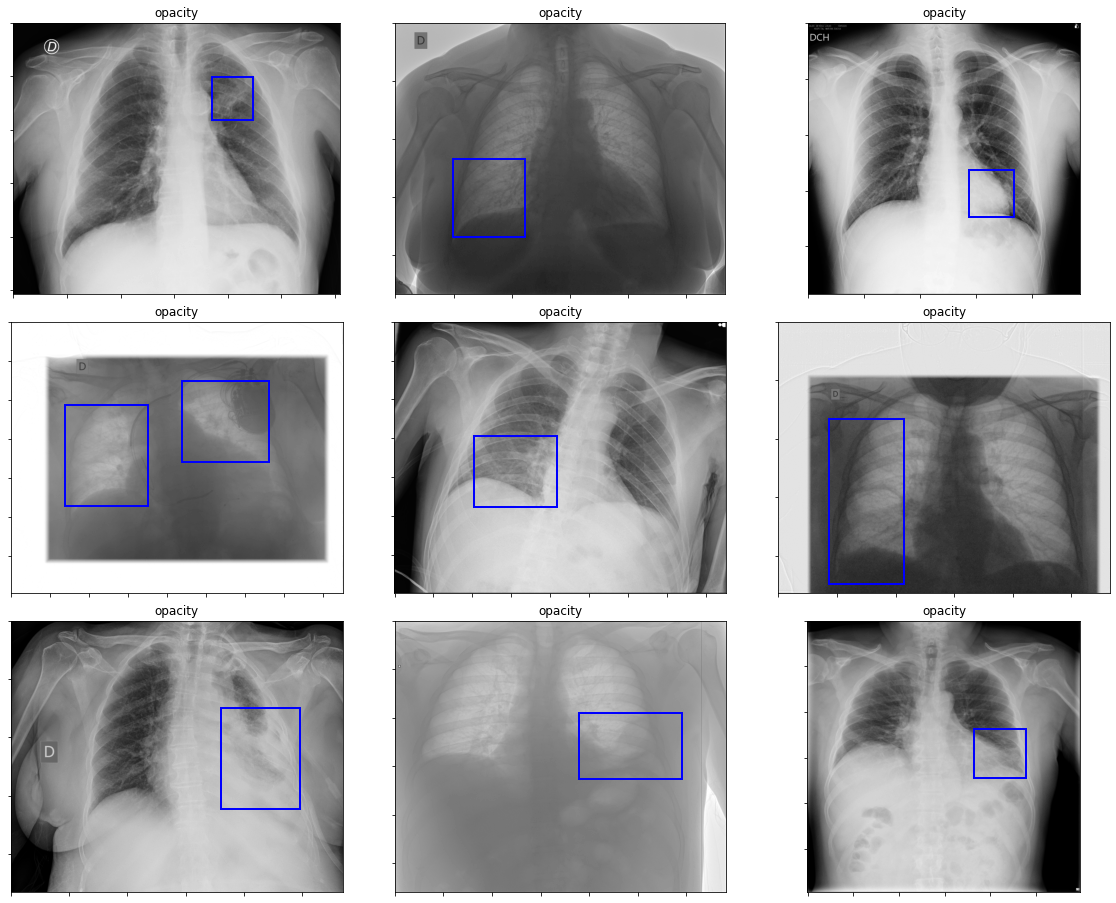

In [78]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Indeterminate_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='b', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 8-d. Atypical Appearance

In [79]:
Atypical_Idx = list(train_df[train_df[OpacityType[3]]==1].index)
Atypical_Idx[:9]

[3, 16, 53, 76, 124, 136, 155, 183, 197]

In [80]:
train_df.iloc[Atypical_Idx, :]

id                                              boxes  \
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
16    008ca392cff3_image  [{'x': 2284.17508, 'y': 1342.64878, 'width': 1...   
53    0199e056a941_image  [{'x': 525.27996, 'y': 2485.7, 'width': 1286.4...   
76    025bf835bba6_image                                                NaN   
124   0449b62bc0b6_image  [{'x': 1738.0842, 'y': 491.24506, 'width': 764...   
...                  ...                                                ...   
6282  fe1ce39cfa13_image                                                NaN   
6300  fe94f73e3072_image  [{'x': 2887.40002, 'y': 1557.86664, 'width': 1...   
6312  fef5d9dd40e4_image                                                NaN   
6318  ff339bf108b4_image  [{'x': 608.21586, 'y': 1747.03748, 'width': 75...   
6320  ff4cd60f14b7_image                                                NaN   

                                                  label StudyInstanceUID  \
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
16    opacity 1 2284.17508 1342.64878 3307.2952 2708...     39a80a14bfda   
53    opacity 1 525.27996 2485.7 1811.67996 3463.899...     3a2ab0d08864   
76                                       none 1 0 0 1 1     f4ead5d70ba6   
124   opacity 1 1738.0842 491.24506 2502.94284 1838....     b66a03d385b2   
...                                                 ...              ...   
6282                                     none 1 0 0 1 1     71e052c9da68   
6300  opacity 1 2887.40002 1557.86664 3987.40002 231...     9945a45c802e   
6312                                     none 1 0 0 1 1     4b4d19205cf6   
6318  opacity 1 608.21586 1747.03748 1366.61979 2302...     f4f46fb7a346   
6320                                     none 1 0 0 1 1     be16979f2071   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
3                1                       0                   0   
16               1                       0                   0   
53               2                       0                   0   
76               0                       0                   0   
124              1                       0                   0   
...            ...                     ...                 ...   
6282             0                       0                   0   
6300             1                       0                   0   
6312             0                       0                   0   
6318             1                       0                   0   
6320             0                       0                   0   

      Indeterminate Appearance  Atypical Appearance  
3                            0                    1  
16                           0                    1  
53                           0                    1  
76                           0                    1  
124                          0                    1  
...                        ...                  ...  
6282                         0                    1  
6300                         0                    1  
6312                         0                    1  
6318                         0                    1  
6320                         0                    1  

[483 rows x 9 columns]

index : 3 - DCM File Path :/kaggle/input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
index : 16 - DCM File Path :/kaggle/input/siim-covid19-detection/train/39a80a14bfda/088a20979e31/008ca392cff3.dcm
index : 53 - DCM File Path :/kaggle/input/siim-covid19-detection/train/3a2ab0d08864/e02fb2598cda/0199e056a941.dcm
index : 76 - DCM File Path :/kaggle/input/siim-covid19-detection/train/f4ead5d70ba6/a34c54f5b21c/025bf835bba6.dcm
index : 124 - DCM File Path :/kaggle/input/siim-covid19-detection/train/b66a03d385b2/13ee505d1521/0449b62bc0b6.dcm
index : 136 - DCM File Path :/kaggle/input/siim-covid19-detection/train/fcf51aeb5fab/6732a5f0ba17/04c1af6cb8df.dcm
index : 155 - DCM File Path :/kaggle/input/siim-covid19-detection/train/b65e52a96289/82268a05f55d/051c0c15073e.dcm
index : 183 - DCM File Path :/kaggle/input/siim-covid19-detection/train/109b53420475/5fb6e1526e47/061797f81be0.dcm
index : 197 - DCM File Path :/kaggle/input/siim-covid19-detection/train/1073d1b6ddcc/

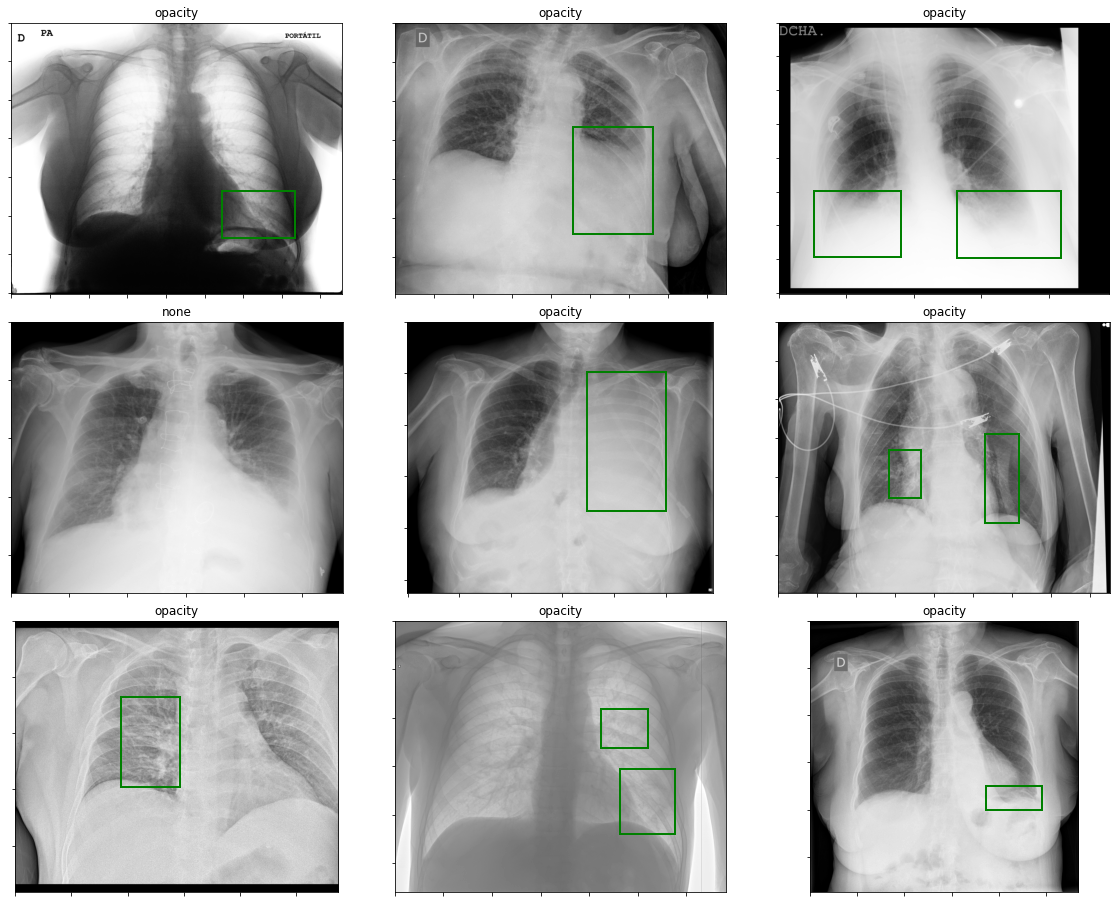

In [81]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Atypical_Idx[:9]:
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='g', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

## 9. Feature Engineering III


Outliers detected through above visualizations. let's check them

In [82]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1)]

id boxes           label StudyInstanceUID  OpacityCount  \
22    00c1515729a8_image   NaN  none 1 0 0 1 1     1a58b43cf286             0   
31    0102b5cac730_image   NaN  none 1 0 0 1 1     81f6b4b343f7             0   
32    b3ffe59e37c7_image   NaN  none 1 0 0 1 1     81f6b4b343f7             0   
76    025bf835bba6_image   NaN  none 1 0 0 1 1     f4ead5d70ba6             0   
129   04a0b90d7875_image   NaN  none 1 0 0 1 1     effcdb73627e             0   
...                  ...   ...             ...              ...           ...   
6194  fa38e3491eec_image   NaN  none 1 0 0 1 1     8087e3bc0efe             0   
6213  fb38bfebfabd_image   NaN  none 1 0 0 1 1     37f638aff743             0   
6282  fe1ce39cfa13_image   NaN  none 1 0 0 1 1     71e052c9da68             0   
6312  fef5d9dd40e4_image   NaN  none 1 0 0 1 1     4b4d19205cf6             0   
6320  ff4cd60f14b7_image   NaN  none 1 0 0 1 1     be16979f2071             0   

      Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
22                         0                   1                         0   
31                         0                   1                         0   
32                         0                   1                         0   
76                         0                   0                         0   
129                        0                   1                         0   
...                      ...                 ...                       ...   
6194                       0                   0                         0   
6213                       0                   0                         0   
6282                       0                   0                         0   
6312                       0                   0                         0   
6320                       0                   0                         0   

      Atypical Appearance  
22                      0  
31                      0  
32                      0  
76                      1  
129                     0  
...                   ...  
6194                    1  
6213                    1  
6282                    1  
6312                    1  
6320                    1  

[304 rows x 9 columns]

**Anomaly 304 rows : label is 'none' but Non Negative for Pneumonia**

### 9-a. anomaly detection

- Cases with no opacity detected but classified as symptomatic

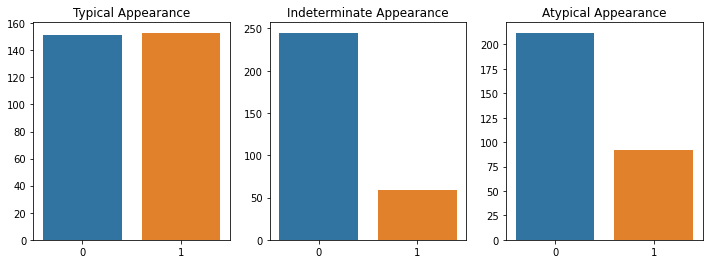

In [83]:
i=0
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
for type in OpacityType[1:]:
    sr = train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1)].loc[:,type].value_counts()
    sns.barplot(x=sr.index, y=sr.values, ax=axes[i])
    axes[i].set_title(type)
    i += 1

In [84]:
Anom_Count = train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1)][OpacityType[1:]].sum()
Anom_Count

Typical Appearance          153
Indeterminate Appearance     59
Atypical Appearance          92
dtype: int64

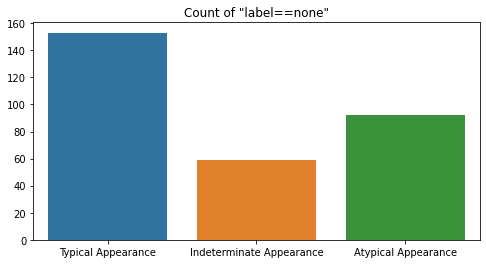

In [85]:
plt.figure(figsize=(8,4))
sns.barplot(x=Anom_Count.index, y=Anom_Count.values)
plt.title('Count of "label==none"')
plt.show()

### 9-b. Show Outliers in `Typical Appearance`

In [105]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Typical Appearance']==1)].head()

id boxes           label StudyInstanceUID  OpacityCount  \
22   00c1515729a8_image   NaN  none 1 0 0 1 1     1a58b43cf286             0   
31   0102b5cac730_image   NaN  none 1 0 0 1 1     81f6b4b343f7             0   
32   b3ffe59e37c7_image   NaN  none 1 0 0 1 1     81f6b4b343f7             0   
129  04a0b90d7875_image   NaN  none 1 0 0 1 1     effcdb73627e             0   
151  deea6d6f81a5_image   NaN  none 1 0 0 1 1     6e4a0581cefe             0   

     Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
22                        0                   1                         0   
31                        0                   1                         0   
32                        0                   1                         0   
129                       0                   1                         0   
151                       0                   1                         0   

     Atypical Appearance  
22                     0  
31                     0  
32                     0  
129                    0  
151                    0

In [87]:
Outlier_Typical_Idx = list(train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Typical Appearance']==1)].index)
Outlier_Typical_Idx[:6]

[22, 31, 32, 129, 151, 162]

index : 22 - DCM File Path :/kaggle/input/siim-covid19-detection/train/1a58b43cf286/461096d084ba/00c1515729a8.dcm
index : 31 - DCM File Path :/kaggle/input/siim-covid19-detection/train/81f6b4b343f7/84c1e7460c8d/0102b5cac730.dcm
index : 32 - DCM File Path :/kaggle/input/siim-covid19-detection/train/81f6b4b343f7/e5a1046cf2e2/b3ffe59e37c7.dcm
index : 129 - DCM File Path :/kaggle/input/siim-covid19-detection/train/effcdb73627e/eee19c1d75b0/04a0b90d7875.dcm
index : 151 - DCM File Path :/kaggle/input/siim-covid19-detection/train/6e4a0581cefe/416e15e074d2/deea6d6f81a5.dcm
index : 162 - DCM File Path :/kaggle/input/siim-covid19-detection/train/adbfed2da701/2f0a137f88c1/a174a4f6c807.dcm


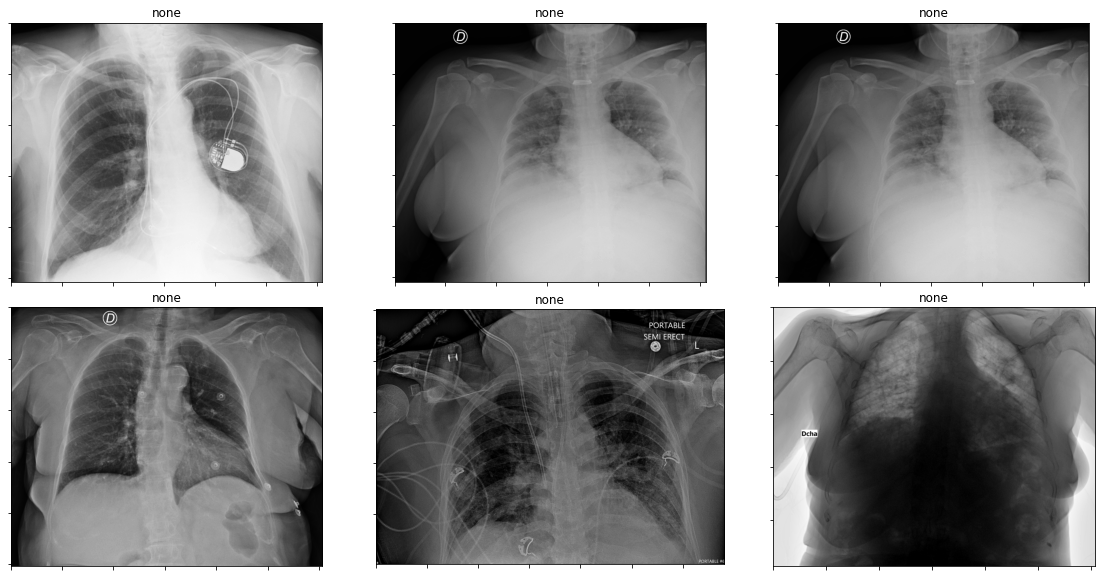

In [96]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Outlier_Typical_Idx[:6]:
    img = error_processed_extraction(idx)

    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 9-c. Show Outliers in `Indeterminate Appearance`

In [102]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Indeterminate Appearance']==1)].head()

id boxes           label StudyInstanceUID  OpacityCount  \
137  04cc2f7f4c4b_image   NaN  none 1 0 0 1 1     0fd2db233deb             0   
138  05c063f5cef5_image   NaN  none 1 0 0 1 1     0fd2db233deb             0   
139  156cb1f5c689_image   NaN  none 1 0 0 1 1     0fd2db233deb             0   
141  4c414b793562_image   NaN  none 1 0 0 1 1     0fd2db233deb             0   
142  a5a364383f34_image   NaN  none 1 0 0 1 1     0fd2db233deb             0   

     Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
137                       0                   0                         1   
138                       0                   0                         1   
139                       0                   0                         1   
141                       0                   0                         1   
142                       0                   0                         1   

     Atypical Appearance  
137                    0  
138                    0  
139                    0  
141                    0  
142                    0

In [97]:
Outlier_Indeterminate_Idx = list(train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Indeterminate Appearance']==1)].index)
Outlier_Indeterminate_Idx[:6]

[137, 138, 139, 141, 142, 143]

index : 137 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0fd2db233deb/f759743147f8/04cc2f7f4c4b.dcm
index : 138 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0fd2db233deb/06feab2c43b9/05c063f5cef5.dcm
index : 139 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0fd2db233deb/a4fec64f5b97/156cb1f5c689.dcm
index : 141 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0fd2db233deb/6986b53f6431/4c414b793562.dcm
index : 142 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0fd2db233deb/b8c20a915593/a5a364383f34.dcm
index : 143 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0fd2db233deb/2019d0f0cd58/b121806162c3.dcm


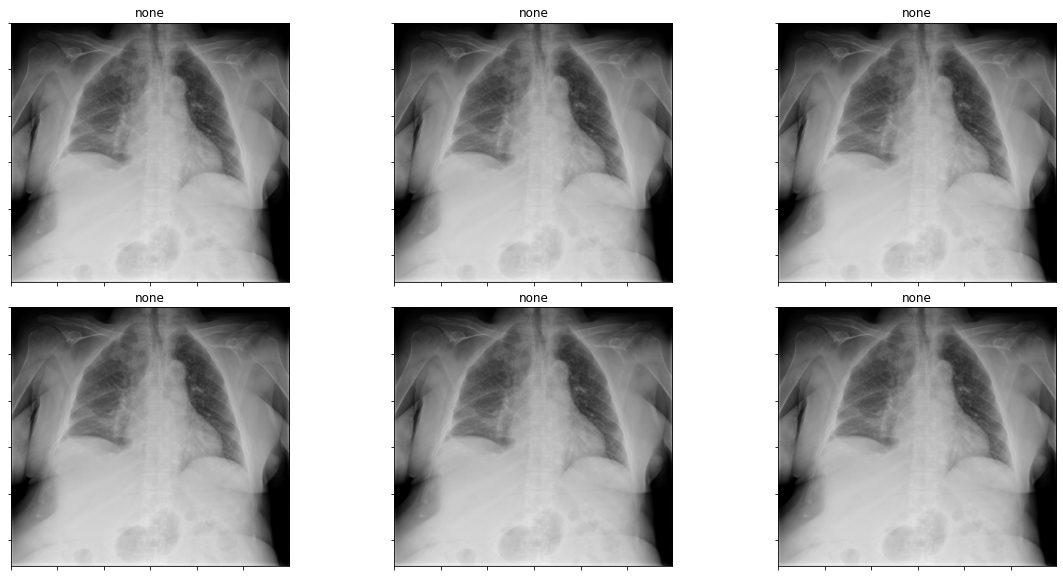

In [98]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Outlier_Indeterminate_Idx[:6]:
    img = error_processed_extraction(idx)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

### 9-d. Show Outliers in `Atypical Appearance`

In [104]:
train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Atypical Appearance']==1)].head()

id boxes           label StudyInstanceUID  OpacityCount  \
76   025bf835bba6_image   NaN  none 1 0 0 1 1     f4ead5d70ba6             0   
239  0842f032a217_image   NaN  none 1 0 0 1 1     0d9709b3af74             0   
240  830063223a31_image   NaN  none 1 0 0 1 1     0d9709b3af74             0   
241  efc93a3917b6_image   NaN  none 1 0 0 1 1     0d9709b3af74             0   
392  0d89b409d464_image   NaN  none 1 0 0 1 1     74b07ad32cf1             0   

     Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
76                        0                   0                         0   
239                       0                   0                         0   
240                       0                   0                         0   
241                       0                   0                         0   
392                       0                   0                         0   

     Atypical Appearance  
76                     1  
239                    1  
240                    1  
241                    1  
392                    1

In [99]:
Outlier_Atypical_Idx = list(train_df[(train_df['OpacityCount']==0) & (train_df['Negative for Pneumonia']!=1) & (train_df['Atypical Appearance']==1)].index)
Outlier_Atypical_Idx[:6]

[76, 239, 240, 241, 392, 464]

index : 76 - DCM File Path :/kaggle/input/siim-covid19-detection/train/f4ead5d70ba6/a34c54f5b21c/025bf835bba6.dcm
index : 239 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0d9709b3af74/094a086f0e1b/0842f032a217.dcm
index : 240 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0d9709b3af74/4e7268348ca6/830063223a31.dcm
index : 241 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0d9709b3af74/8a562374d8d6/efc93a3917b6.dcm
index : 392 - DCM File Path :/kaggle/input/siim-covid19-detection/train/74b07ad32cf1/d382abb5e7c9/0d89b409d464.dcm
index : 464 - DCM File Path :/kaggle/input/siim-covid19-detection/train/76d3ada42326/ee4c3facdc52/10336427905f.dcm


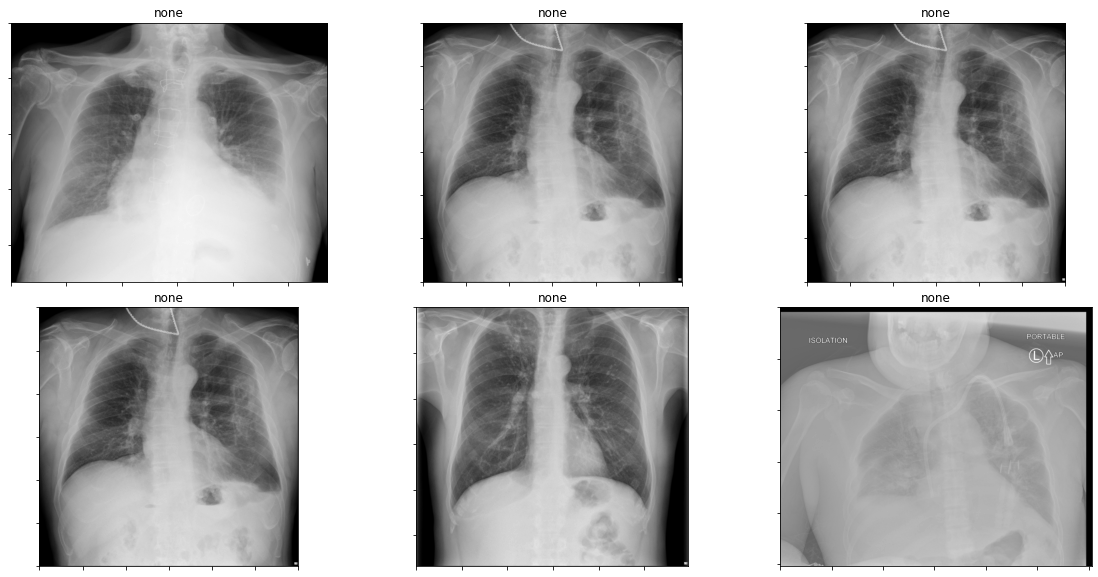

In [100]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in Outlier_Atypical_Idx[:6]:
    img = error_processed_extraction(idx)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

## Step 10. Image Data Preprocessing

In [161]:
from glob import glob

In [151]:
for _, row in train_df.iloc[:5].iterrows():
    print(row)

id                                                         000a312787f2_image
boxes                       [{'x': 789.28836, 'y': 582.43035, 'width': 102...
label                       opacity 1 789.28836 582.43035 1815.94498 2499....
StudyInstanceUID                                                 5776db0cec75
OpacityCount                                                                2
Negative for Pneumonia                                                      0
Typical Appearance                                                          1
Indeterminate Appearance                                                    0
Atypical Appearance                                                         0
Name: 0, dtype: object
id                          000c3a3f293f_image
boxes                                      NaN
label                           none 1 0 0 1 1
StudyInstanceUID                  ff0879eb20ed
OpacityCount                                 0
Negative for Pneumonia                  

In [157]:
for _, row in train_df.iloc[:5].iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    print(img_path)

['/kaggle/input/siim-covid19-detection//train/5776db0cec75/81456c9c5423/000a312787f2.dcm']
['/kaggle/input/siim-covid19-detection//train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm']
['/kaggle/input/siim-covid19-detection//train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm']
['/kaggle/input/siim-covid19-detection//train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm']
['/kaggle/input/siim-covid19-detection//train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm']


In [158]:
path_list = []
for _, row in train_df.iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    img_path = glob(f'{path}/train/{study_id}/*/{image_id}.dcm')
    if len(img_path)==1:
        path_list.append(img_path[0])
    else:
        print(img_path)

In [159]:
len(path_list)

6334

In [160]:
path_list[:10]

['/kaggle/input/siim-covid19-detection//train/5776db0cec75/81456c9c5423/000a312787f2.dcm',
 '/kaggle/input/siim-covid19-detection//train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm',
 '/kaggle/input/siim-covid19-detection//train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm',
 '/kaggle/input/siim-covid19-detection//train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm',
 '/kaggle/input/siim-covid19-detection//train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm',
 '/kaggle/input/siim-covid19-detection//train/84543edc24c2/82f65ab98ee0/0022227f5adf.dcm',
 '/kaggle/input/siim-covid19-detection//train/2fa400b873f5/0d5c637b277d/0023f02ae886.dcm',
 '/kaggle/input/siim-covid19-detection//train/0717c8ac304f/849b8c217a5e/002e9b2128d0.dcm',
 '/kaggle/input/siim-covid19-detection//train/a81050391441/85b77baa8ffe/00326161e51e.dcm',
 '/kaggle/input/siim-covid19-detection//train/b60f2d2cc642/72527a76d460/0044e449aae1.dcm']

All Image path have been saved (6334)

In [162]:
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

In [284]:
train_df

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
0                2                       0                   1   
1                0                       1                   0   
2                2                       0                   1   
3                1                       0                   0   
4                2                       0                   1   
...            ...                     ...                 ...   
6329             0                       1                   0   
6330             0                       1                   0   
6331             3                       0                   1   
6332             2                       0                   1   
6333             2                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    0  
2                            0                    0  
3                            0                    1  
4                            0                    0  
...                        ...                  ...  
6329                         0                    0  
6330                         0                    0  
6331                         0                    0  
6332                         0                    0  
6333                         0                    0  

[6334 rows x 9 columns]

In [255]:
data_file = dicom.read_file(path_list[0])

In [242]:
data_file.pixel_array

array([[2809, 2799, 2836, ...,   63, 1791,    0],
       [2815, 2804, 2861, ...,   63, 2540,    0],
       [2867, 2872, 2918, ...,   63, 2545,    0],
       ...,
       [  55,   55,   55, ...,   43,   43,    0],
       [  53,   53,   54, ...,   45,   43,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [264]:
data_file

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.135099524260102611886915167296699866712
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 000a312787f2
(0008, 0020) Study Date                          DA: '526316e376d4'
(0008, 0030) Study Time                          TM: '8ccfb6acf07f'
(0008, 0050) Accession Number                    SH: 'f6cd7f2019f5'
(0008, 0060) Modality                            CS: 'DX'
(0010, 0010) Patient's Name                      PN: 'd4268f26ed05'
(

In [244]:
data_file.Rows

3488

In [245]:
data_file.Columns

4256

In [262]:
def extract_img_size(path_list):
    origin_img_heights = []
    origin_img_widths = []
    i = 0
    for path in path_list:
        data_file = dicom.read_file(path)
        origin_img_heights.append(data_file.Rows)
        origin_img_widths.append(data_file.Columns)
        i += 1
        if i % 100 == 0:
            print('{}/{}'.format(i,len(path_list)))
            
    return origin_img_heights, origin_img_widths

In [267]:
def extract_resized_and_origin_img_info(path_list, voi_lut=True, fix_monochrome=True):
    img_list = []
    origin_img_height = []
    origin_img_width = []
    i = 0
    for path in path_list:
        data_file = dicom.read_file(path)
        
        if voi_lut == True:
            img = apply_voi_lut(data_file.pixel_array, data_file)
        else:
            img = data_file.pixel_array

            
        print(img.shape)
        origin_img_height.append(img.shape[0])
        origin_img_width.append(img.shape[1])
        
        if (fix_monochrome == True) & (data_file.PhotometricInterpretation == "MONOCHROME1"):
            img = np.amax(img)-img
        
        # scailing to 0~255
        img = (img - np.min(img)) / np.max(img)
        img = (img * 255).astype(np.uint8)
        
        # resizing to 4000+ to 150 default
        img = cv2.resize(img, (150,150))
        img_list.append(img)
        img_array = np.array(img_list)
        print(img.shape)
        i += 1
        if i % 100 == 0:
            print('{} / {}'.format(len(img_array),len(path_list)))
    return img_array, origin_img_height, origin_img_width

In [270]:
test, origin_img_height, origin_img_width = extract_resized_and_origin_img_info(path_list[:9])

(3488, 4256)
(150, 150)
(2320, 2832)
(150, 150)
(2544, 3056)
(150, 150)
(3520, 4280)
(150, 150)
(2800, 3408)
(150, 150)
(2539, 3050)
(150, 150)
(2330, 2846)
(150, 150)
(2416, 2872)
(150, 150)
(2336, 2836)
(150, 150)


In [271]:
origin_img_height

[3488, 2320, 2544, 3520, 2800, 2539, 2330, 2416, 2336]

In [272]:
origin_img_width

[4256, 2832, 3056, 4280, 3408, 3050, 2846, 2872, 2836]

In [291]:
x_scale_list=[]
y_scale_list=[]
for i in range(len(origin_img_height)):
    x_scale = 150 / origin_img_height[i]
    x_scale_list.append(x_scale)
    print(i)
    y_scale = 150 / origin_img_width[i]
    y_scale_list.append(y_scale)

0
1
2
3
4
5
6
7
8


In [280]:
x_scale_list

[0.0430045871559633,
 0.06465517241379311,
 0.0589622641509434,
 0.04261363636363636,
 0.05357142857142857,
 0.05907837731390311,
 0.06437768240343347,
 0.062086092715231786,
 0.0642123287671233]

In [281]:
y_scale_list

[0.03524436090225564,
 0.05296610169491525,
 0.04908376963350786,
 0.035046728971962614,
 0.04401408450704225,
 0.04918032786885246,
 0.05270555165144062,
 0.05222841225626741,
 0.05289139633286319]

In [290]:
box['x']*x_scale

111.95153296232878

index : 0 - DCM File Path :/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
index : 1 - DCM File Path :/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
index : 2 - DCM File Path :/kaggle/input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
index : 3 - DCM File Path :/kaggle/input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
index : 4 - DCM File Path :/kaggle/input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm
index : 5 - DCM File Path :/kaggle/input/siim-covid19-detection/train/84543edc24c2/82f65ab98ee0/0022227f5adf.dcm
index : 6 - DCM File Path :/kaggle/input/siim-covid19-detection/train/2fa400b873f5/0d5c637b277d/0023f02ae886.dcm
index : 7 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0717c8ac304f/849b8c217a5e/002e9b2128d0.dcm
index : 8 - DCM File Path :/kaggle/input/siim-covid19-detection/train/a81050391441/85b77baa8ffe/

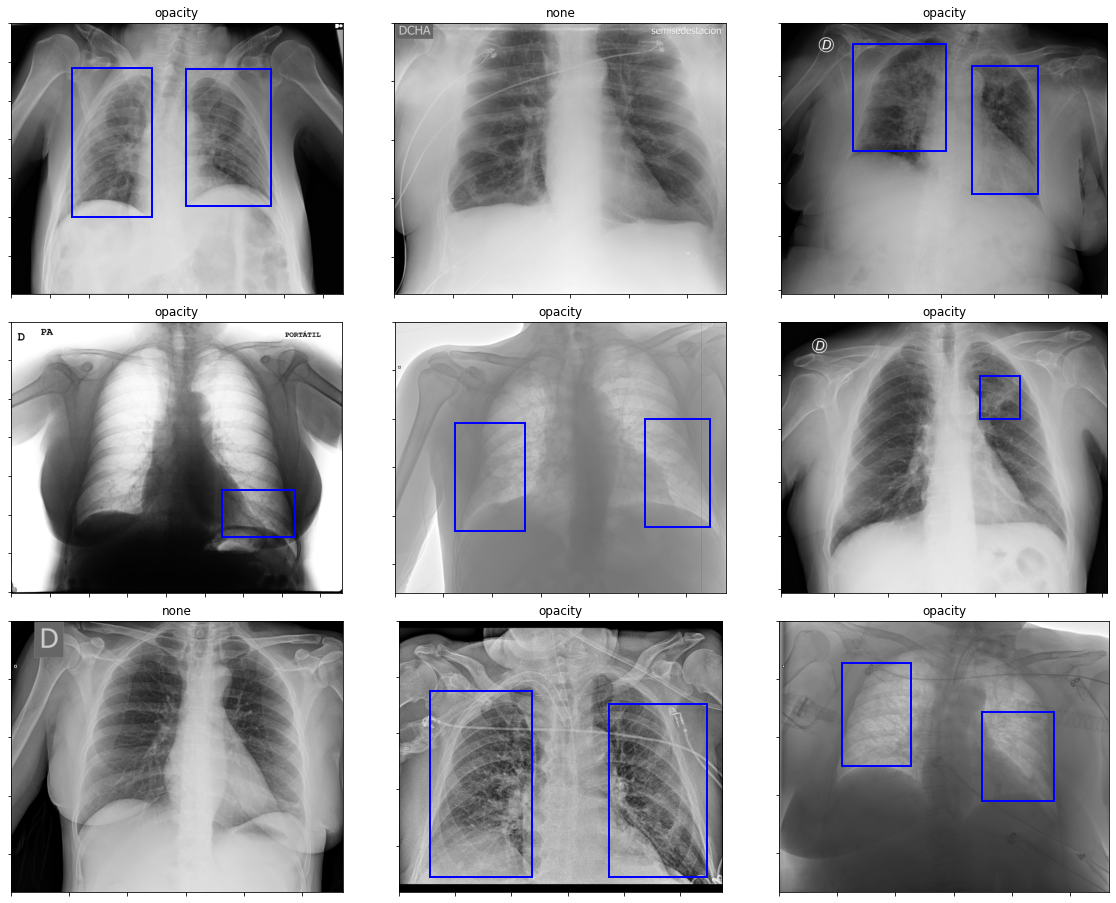

In [286]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in range(9):
    img = error_processed_extraction(idx)
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='b', fc='none', lw=2.)
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

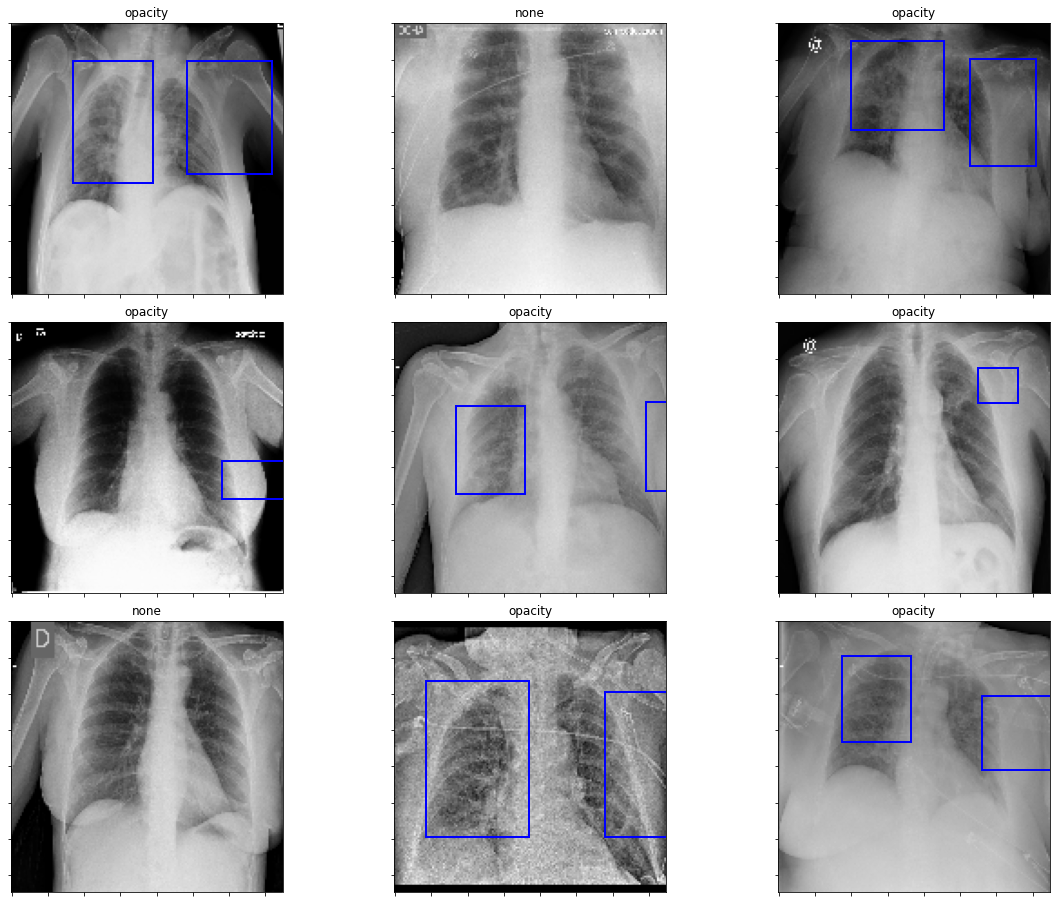

In [282]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()
row = 0
for idx in range(9):
    img = img_array[idx]
    # if (nan == nan)
    # False
    if (train_df.loc[idx,'boxes'] == train_df.loc[idx,'boxes']):
        boxes = ast.literal_eval(train_df.loc[idx,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x']*x_scale_list[idx], box['y']*y_scale_list[idx]),
                                              box['width']*x_scale_list[idx], box['height']*y_scale_list[idx],
                                              ec='b', fc='none', lw=2.)
            axes[row].add_patch(p)
    
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(train_df.loc[idx, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])
    row += 1

In [185]:
img_array = extract_resized_dataset(path_list)

100 / 6334
200 / 6334
300 / 6334
400 / 6334
500 / 6334
600 / 6334
700 / 6334
800 / 6334
900 / 6334
1000 / 6334
1100 / 6334
1200 / 6334
1300 / 6334
1400 / 6334
1500 / 6334
1600 / 6334
1700 / 6334
1800 / 6334
1900 / 6334
2000 / 6334
2100 / 6334
2200 / 6334
2300 / 6334
2400 / 6334
2500 / 6334
2600 / 6334
2700 / 6334
2800 / 6334
2900 / 6334
3000 / 6334
3100 / 6334
3200 / 6334
3300 / 6334
3400 / 6334
3500 / 6334
3600 / 6334
3700 / 6334
3800 / 6334
3900 / 6334
4000 / 6334
4100 / 6334
4200 / 6334
4300 / 6334
4400 / 6334
4500 / 6334
4600 / 6334
4700 / 6334
4800 / 6334
4900 / 6334
5000 / 6334
5100 / 6334
5200 / 6334
5300 / 6334
5400 / 6334
5500 / 6334
5600 / 6334
5700 / 6334
5800 / 6334
5900 / 6334
6000 / 6334
6100 / 6334
6200 / 6334
6300 / 6334


In [191]:
img_array.shape

(6334, 150, 150)

In [194]:
img_array.reshape((6334, 150, 150, -1)).shape

(6334, 150, 150, 1)

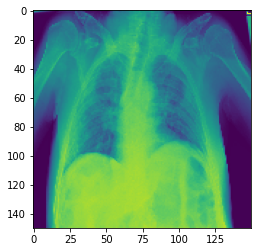

In [206]:
plt.imshow(img_array[0])

In [195]:
train_df

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
0                2                       0                   1   
1                0                       1                   0   
2                2                       0                   1   
3                1                       0                   0   
4                2                       0                   1   
...            ...                     ...                 ...   
6329             0                       1                   0   
6330             0                       1                   0   
6331             3                       0                   1   
6332             2                       0                   1   
6333             2                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    0  
2                            0                    0  
3                            0                    1  
4                            0                    0  
...                        ...                  ...  
6329                         0                    0  
6330                         0                    0  
6331                         0                    0  
6332                         0                    0  
6333                         0                    0  

[6334 rows x 9 columns]

In [ ]:
def get_bbox(row):
    bboxes = []
    bbox = []
    for i, l in enumerate(row.label.split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l))
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []  
            
    return bboxes

# Scale the bounding boxes according to the size of the resized image. 
def scale_bbox(row, bboxes):
    # Get scaling factor
    scale_x = IMG_SIZE/row.dim1
    scale_y = IMG_SIZE/row.dim0
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = int(np.round(bbox[0]*scale_x, 4))
        y = int(np.round(bbox[1]*scale_y, 4))
        x1 = int(np.round(bbox[2]*(scale_x), 4))
        y1= int(np.round(bbox[3]*scale_y, 4))

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

In [226]:
bboxes

[[0.0, 0.0, 1.0, 1.0]]

In [198]:
import pickle

filePath = './img_array.txt'
with open(filePath, 'wb') as w:
    pickle.dump(img_array, w)

In [200]:
with open(filePath, 'rb') as r:
    readList = pickle.load(r)
    print(readList.shape)

(6334, 150, 150)


In [107]:
img = error_processed_extraction(1)
img.shape

index : 1 - DCM File Path :/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm


(2320, 2832)

In [121]:
for i in range(10):
    img = error_processed_extraction(i)
    print(img.shape)

index : 0 - DCM File Path :/kaggle/input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
(3488, 4256)
index : 1 - DCM File Path :/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
(2320, 2832)
index : 2 - DCM File Path :/kaggle/input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
(2544, 3056)
index : 3 - DCM File Path :/kaggle/input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
(3520, 4280)
index : 4 - DCM File Path :/kaggle/input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm
(2800, 3408)
index : 5 - DCM File Path :/kaggle/input/siim-covid19-detection/train/84543edc24c2/82f65ab98ee0/0022227f5adf.dcm
(2539, 3050)
index : 6 - DCM File Path :/kaggle/input/siim-covid19-detection/train/2fa400b873f5/0d5c637b277d/0023f02ae886.dcm
(2330, 2846)
index : 7 - DCM File Path :/kaggle/input/siim-covid19-detection/train/0717c8ac304f/849b8c217a5e/002e9b2128d0.dcm
(2416

In [124]:
img.shape

(2336, 2836)

index : 151 - DCM File Path :/kaggle/input/siim-covid19-detection/train/6e4a0581cefe/416e15e074d2/deea6d6f81a5.dcm


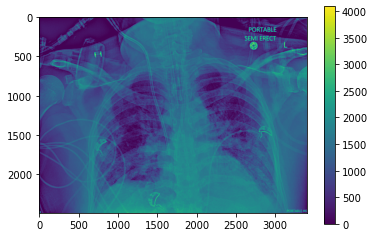

In [115]:
plt.imshow(error_processed_extraction(151))
plt.colorbar()

index : 2 - DCM File Path :/kaggle/input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm


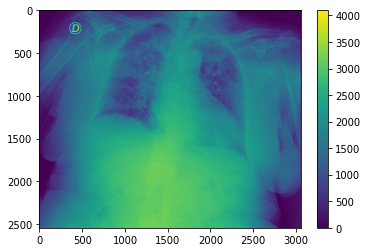

In [114]:
plt.imshow(error_processed_extraction(2))
plt.colorbar()

In [116]:
import cv2
image = cv2.resize(img, (150,150))

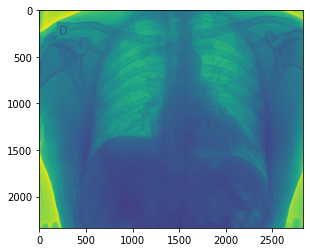

In [127]:
plt.imshow(img)

In [118]:
image.shape

(150, 150)

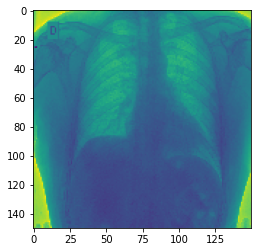

In [125]:
plt.imshow(image)

In [140]:
train_df

id                                              boxes  \
0     000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1     000c3a3f293f_image                                                NaN   
2     0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                  ...                                                ...   
6329  ffcc6edd9445_image                                                NaN   
6330  ffd91a2c4ca0_image                                                NaN   
6331  ffd9b6cf2961_image  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6332  ffdc682f7680_image  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6333  ffe942c8655f_image  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6329                                     none 1 0 0 1 1     7e6c68462e06   
6330                                     none 1 0 0 1 1     8332bdaddb6e   
6331  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6332  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6333  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

      OpacityCount  Negative for Pneumonia  Typical Appearance  \
0                2                       0                   1   
1                0                       1                   0   
2                2                       0                   1   
3                1                       0                   0   
4                2                       0                   1   
...            ...                     ...                 ...   
6329             0                       1                   0   
6330             0                       1                   0   
6331             3                       0                   1   
6332             2                       0                   1   
6333             2                       0                   1   

      Indeterminate Appearance  Atypical Appearance  
0                            0                    0  
1                            0                    0  
2                            0                    0  
3                            0                    1  
4                            0                    0  
...                        ...                  ...  
6329                         0                    0  
6330                         0                    0  
6331                         0                    0  
6332                         0                    0  
6333                         0                    0  

[6334 rows x 9 columns]